# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [4]:
cust.shape

(99999, 226)

In [5]:
cust.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...            0        1.0        1.0   
1            9/30/2014   34.047  ...            0        NaN        1.0   
2            9/30/2014  167.690  ...            0        NaN        NaN   
3            9/30/2014  221.338  ...            0        NaN        NaN   
4            9/30/2014  261.636  ...            0        0.0        NaN   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0        1.0        NaN   968        30.4         0.0      101.20        3.58  
1        1.0        NaN  1006         0.0         0.0        0.00        0.00  
2        NaN        1.0  1103         0.0         0.0        4.17        0.00  
3        NaN        NaN  2491         0.0         0.0        0.00        0.00  
4        NaN        NaN  1526         0.0         0.0        0.00        0.00  

[5 rows x 226 columns]

In [6]:
# Smaller file to manually check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [7]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [8]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        #"Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## <TODO> Check data types

In [9]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Date columns are present as objects. Convert to datetime type.

In [10]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime,errors='coerce') 

## Check for missing data

In [11]:
print_missing_columns(cust)

Missing  Missing %  Unique Count
count_rech_2g_6             74846  74.846748            31
max_rech_data_6             74846  74.846748            48
arpu_3g_6                   74846  74.846748          7418
av_rech_amt_data_6          74846  74.846748           887
count_rech_3g_6             74846  74.846748            25
night_pck_user_6            74846  74.846748             2
arpu_2g_6                   74846  74.846748          6990
fb_user_6                   74846  74.846748             2
total_rech_data_6           74846  74.846748            37
date_of_last_rech_data_6    74846  74.846748            30
count_rech_3g_7             74428  74.428744            28
arpu_3g_7                   74428  74.428744          7246
av_rech_amt_data_7          74428  74.428744           961
fb_user_7                   74428  74.428744             2
total_rech_data_7           74428  74.428744            42
count_rech_2g_7             74428  74.428744            36
arpu_2g_7                   74428  74.428744          6586
night_pck_user_7            74428  74.428744             2
max_rech_data_7             74428  74.428744            48
date_of_last_rech_data_7    74428  74.428744            31
date_of_last_rech_data_9    74077  74.077741            30
count_rech_2g_9             74077  74.077741            32
total_rech_data_9           74077  74.077741            37
count_rech_3g_9             74077  74.077741            27
max_rech_data_9             74077  74.077741            50
av_rech_amt_data_9          74077  74.077741           945
arpu_3g_9                   74077  74.077741          8063
fb_user_9                   74077  74.077741             2
night_pck_user_9            74077  74.077741             2
arpu_2g_9                   74077  74.077741          6795
...                           ...        ...           ...
std_og_t2m_mou_7             3859   3.859039         20018
std_og_t2f_mou_7             3859   3.859039          2391
std_og_t2c_mou_7             3859   3.859039             1
roam_ic_mou_7                3859   3.859039          5230
isd_og_mou_7                 3859   3.859039          1380
spl_og_mou_7                 3859   3.859039          4396
og_others_7                  3859   3.859039           187
loc_ic_t2t_mou_7             3859   3.859039         13511
loc_ic_t2m_mou_7             3859   3.859039         21918
offnet_mou_7                 3859   3.859039         31023
loc_ic_mou_7                 3859   3.859039         28390
std_ic_t2t_mou_7             3859   3.859039          6481
std_ic_t2m_mou_7             3859   3.859039          9464
std_ic_t2f_mou_7             3859   3.859039          3209
std_ic_t2o_mou_7             3859   3.859039             1
std_ic_mou_7                 3859   3.859039         11889
spl_ic_mou_7                 3859   3.859039           107
isd_ic_mou_7                 3859   3.859039          5789
ic_others_7                  3859   3.859039          2002
onnet_mou_7                  3859   3.859039         24336
loc_og_t2t_mou_7             3859   3.859039         13411
date_of_last_rech_8          3622   3.622036            31
date_of_last_rech_7          1767   1.767018            31
last_date_of_month_9         1659   1.659017             1
date_of_last_rech_6          1607   1.607016            30
last_date_of_month_8         1100   1.100011             1
std_og_t2o_mou               1018   1.018010             1
loc_ic_t2o_mou               1018   1.018010             1
loc_og_t2o_mou               1018   1.018010             1
last_date_of_month_7          601   0.601006             1

[166 rows x 3 columns]

## Handle missing data

### Replace missing with 0
- Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type
- Recharge related columns can be set to 0 assuming empty cells indicate no recharge was done in that month
- Minutes of Usage (MoU) and average revenue per user (arpu) columns are also handled similarly 

In [12]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [13]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [14]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [15]:
# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = cust[mou_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(mou_cols)} OFFNET/ONNET MOU columns :{mou_cols}')

Replaced missing values with 0 for 8 OFFNET/ONNET MOU columns :['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']


In [16]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

- Last recharges made for talktime and data for each month is provided in the input data<br>
- With this information, we will create a new derived column which has the number of days since the last recharge <br>
- Combine the columns for the good phase & action phase (months 6, 7 & 8) and get the latest date when a recharge was made <br>
- At the beginning of 9th month, get the number of days since the last recharge <br>
<br>
Hypothesis - if the customer has done a recharge recently, they are less likely to churn.  <br>

In [17]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [18]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [19]:
cust[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].tail()

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8
99994          2014-06-03          2014-07-20          2014-08-26
99995          2014-06-17          2014-07-17          2014-08-24
99996          2014-06-13          2014-07-26                 NaT
99997          2014-06-17          2014-07-19          2014-08-20
99998          2014-06-16                 NaT                 NaT

In [20]:
# Find the last recharge date in the good phase & action phase (gaphase) together (Months 6,7,8)
last_rech_date_cols = [col for col in cust.columns if re.match('^date_of_last_.*[_6|_7|_8]$', col)]
cust['last_rech_date_gaphase'] = cust[last_rech_date_cols].apply(lambda x: x.max(),axis=1)

In [21]:
# Check for missing values
cust['last_rech_date_gaphase'].isnull().sum()

99

In [22]:
# Missing values in this new column implies no recharge has happend in the 3 months.
# Fill missing value with last date of previous month before the start of good phase
last_rech_date_missing = datetime.datetime(2014, 5, 31)
cust['last_rech_date_gaphase']=cust['last_rech_date_gaphase'].fillna(last_rech_date_missing)

In [23]:
# Create column for number of  days since last recharge
last_date_action_phase = datetime.datetime(2014, 8, 31)
cust['last_rech_num_days'] = (last_date_action_phase - cust['last_rech_date_gaphase']).dt.days

In [24]:
cust[['last_rech_date_gaphase','last_rech_num_days']].head()

last_rech_date_gaphase  last_rech_num_days
0             2014-08-08                  23
1             2014-08-28                   3
2             2014-08-14                  17
3             2014-08-31                   0
4             2014-08-09                  22

In [25]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
cust.drop('last_rech_date_gaphase',inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 228)
Shape after dropping date columns:(99999, 215)


In [26]:
print_missing_columns(cust)

Missing  Missing %  Unique Count
night_pck_user_6    74846  74.846748             2
fb_user_6           74846  74.846748             2
night_pck_user_7    74428  74.428744             2
fb_user_7           74428  74.428744             2
night_pck_user_9    74077  74.077741             2
fb_user_9           74077  74.077741             2
night_pck_user_8    73660  73.660737             2
fb_user_8           73660  73.660737             2

The remaining missing values are filled using the IterativeImputer in sklearn

### IterativeImputer

In [27]:
# Use iterative imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

cust[fb_night_cols] = iter_imputer.fit_transform(cust[fb_night_cols])

In [28]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## Check & Treat for outliers

In [29]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         99999.0         99999.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
1%      7.000025e+09      109.0             0.0             0.0   
5%      7.000122e+09      109.0             0.0             0.0   
10%     7.000244e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
90%     7.002174e+09      109.0             0.0             0.0   
95%     7.002291e+09      109.0             0.0             0.0   
99%     7.002387e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         99999.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
1%                0.0      0.000000      0.000000      0.000000      0.000000   
5%                0.0      1.500000      0.750000      0.000000      0.000000   
10%               0.0     31.647200     29.355800     18.054200      0.090000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
90%               0.0    620.075400    617.252000    618.160400    601.537000   
95%               0.0    829.488200    828.357200    833.303300    805.107200   
99%               0.0   1410.792540   1428.685880   1455.539960   1402.445660   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6  ...     fb_user_6     fb_user_7     fb_user_8  \
count  99999.000000  ...  99999.000000  99999.000000  99999.000000   
mean     127.183397  ...      0.854851      0.845752      0.839821   
std      292.433718  ...      0.209511      0.220306      0.227753   
min        0.000000  ...     -0.071595     -0.134228     -0.131123   
1%         0.000000  ...      0.000000      0.000000      0.000000   
5%         0.000000  ...      0.166901      0.139313      0.077313   
10%        0.000000  ...      0.854851      0.845752      0.839821   
25%        5.430000  ...      0.854851      0.845752      0.839821   
50%       30.980000  ...      0.854851      0.845752      0.839821   
75%      112.610000  ...      0.997024      0.996959      0.996960   
90%      330.590000  ...      1.000000      1.000000      1.000000   
95%      594.285000  ...      1.000000      1.000000      1.000000   
99%     1410.511400  ...      1.000000      1.000000      1.000000   
max     7376.710000  ...      1.159101      1.134316      1.139943   

          fb_user_9           aon    aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean       0.836040   1219.854749     68.170248     66.839062     60.021204   
std        0.230755    954.733842    267.580450    271.201856    253.938223   
min       -0.275148    180.000000      0.000000      0.000000      0.000000   
1%        -0.014127    189.000000      0.000000      0.000000      0.000000   
5%         0.047201    229.000000      0.000000      0.000000      0.000000   
10%        0.836040    286.000000      0.000000      0.000000      0.000000   
25%        0.836040    467.000000      0.000000      0.000000      0.000000   
50%        0.836040    

**NOTE on outliers:** 
- Almost all the columns have outliers in the last one percentile.  
- It requires more domain knowledge to understand on how the outliers should be treated.  
- Some options to treat the outliers:  
    1. Remove rows above the upper cap (could be 99% in this case)
    2. Cap the values in the last percentile to 99%
    3. Don't modify the data if it is expected 
- In this case study, we will check on the arpu columns and remove the outliers in these variables  
 

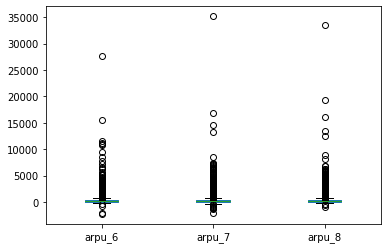

In [30]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [31]:
# Drop outliers with a cap of 99% on the arpu columns
columns_outliers = ['arpu_6','arpu_7','arpu_8']

cap_arpu_6 = cust['arpu_6'].quantile(.99)
cap_arpu_7 = cust['arpu_7'].quantile(.99)
cap_arpu_8 = cust['arpu_8'].quantile(.99)
cust =  cust[(cust['arpu_6'] <= cap_arpu_6) & (cust['arpu_7'] <= cap_arpu_7) & (cust['arpu_8'] <= cap_arpu_8)] 


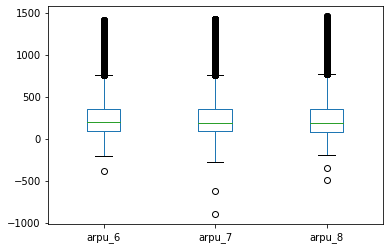

In [32]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [33]:
cust.shape

(98041, 215)

In [34]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.804100e+04    98041.0         98041.0         98041.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.958365e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
1%      7.000025e+09      109.0             0.0             0.0   
5%      7.000122e+09      109.0             0.0             0.0   
10%     7.000244e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001204e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
90%     7.002174e+09      109.0             0.0             0.0   
95%     7.002291e+09      109.0             0.0             0.0   
99%     7.002387e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98041.0  98041.000000  98041.000000  98041.000000  98041.000000   
mean              0.0    260.320312    254.611844    255.664261    242.988043   
std               0.0    236.731151    236.088674    241.455939    253.622200   
min               0.0   -383.565000   -897.035000   -491.545000  -1474.195000   
1%                0.0      0.000000      0.000000      0.000000      0.000000   
5%                0.0      1.350000      0.690000      0.000000      0.000000   
10%               0.0     31.000000     28.510000     17.749000      0.070000   
25%               0.0     91.855000     85.519000     82.788000     61.719000   
50%               0.0    193.467000    187.268000    187.879000    173.205000   
75%               0.0    357.983000    352.190000    356.587000    342.214000   
90%               0.0    580.724000    575.528000    579.512000    567.624000   
95%               0.0    751.653000    745.480000    751.552000    739.841000   
99%               0.0   1094.463000   1085.711200   1121.614800   1149.258800   
max               0.0   1410.789000   1427.887000   1455.232000   5288.685000   

        onnet_mou_6  ...     fb_user_6     fb_user_7     fb_user_8  \
count  98041.000000  ...  98041.000000  98041.000000  98041.000000   
mean     118.270506  ...      0.854513      0.845374      0.839404   
std      256.312305  ...      0.208553      0.219347      0.226764   
min        0.000000  ...     -0.071595     -0.134228     -0.131123   
1%         0.000000  ...      0.000000      0.000000      0.000000   
5%         0.000000  ...      0.166901      0.139313      0.077313   
10%        0.000000  ...      0.854851      0.845752      0.839821   
25%        5.260000  ...      0.854851      0.845752      0.839821   
50%       30.080000  ...      0.854851      0.845752      0.839821   
75%      108.130000  ...      0.997024      0.992909      0.992426   
90%      312.690000  ...      1.000000      1.000000      1.000000   
95%      558.790000  ...      1.000000      1.000000      1.000000   
99%     1281.128000  ...      1.000000      1.000000      1.000000   
max     6109.080000  ...      1.159101      1.134316      1.139943   

          fb_user_9           aon    aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  \
count  98041.000000  98041.000000  98041.000000  98041.000000  98041.000000   
mean       0.835613   1220.918728     62.048232     60.696221     54.210008   
std        0.229805    955.345362    235.716288    240.844109    223.625920   
min       -0.275148    180.000000      0.000000      0.000000      0.000000   
1%        -0.014127    189.000000      0.000000      0.000000      0.000000   
5%         0.047201    229.000000      0.000000      0.000000      0.000000   
10%        0.836040    286.000000      0.000000      0.000000      0.000000   
25%        0.836040    467.000000      0.000000      0.000000      0.000000   
50%        0.836040    

## Remove columns with only one unique value. 
Columns with only one unique value will not add much value to the analysis and can be removed

In [35]:
cust = cust[[col for col in cust.columns if cust[col].nunique() > 1]]


## Drop ID column - mobile_number

In [36]:
cust.drop(['mobile_number'],axis=1,inplace=True)

In [37]:
cust.shape

(98041, 202)

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [38]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [39]:
cust['churn'].value_counts()

0    88102
1     9939
Name: churn, dtype: int64

## Remove 9th month variables

In [40]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(98041, 203)
Shape after dropping 9th month columns:(98041, 154)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [41]:
cust.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  197.385  214.816  213.803         0.00         0.00         0.00   
1   34.047  355.074  268.321        24.11        78.68         7.68   
2  167.690  189.058  210.226        11.54        55.24        37.26   
3  221.338  251.102  508.054        99.91        54.39       310.98   
4  261.636  309.876  238.174        50.31       149.44        83.89   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  ...  fb_user_6  \
0          0.00          0.00          0.00            0.0  ...   1.000000   
1         15.74         99.84        304.76            0.0  ...   0.992156   
2        143.33        220.59        208.36            0.0  ...   0.989024   
3        123.31        109.01         71.68            0.0  ...   0.854851   
4         76.96         91.88        124.26            0.0  ...   0.000000   

   fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  \
0   1.000000   1.000000   968        30.4         0.0      101.20        3.58   
1   1.000000   1.000000  1006         0.0         0.0        0.00        0.00   
2   0.984316   0.989004  1103         0.0         0.0        4.17        0.00   
3   0.845752   0.839821  2491         0.0         0.0        0.00        0.00   
4   0.015115   0.016916  1526         0.0         0.0        0.00        0.00   

   last_rech_num_days  churn  
0                  23      1  
1                   3      0  
2                  17      0  
3                   0      0  
4                  22      0  

[5 rows x 154 columns]

In [42]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


total_rech_num_6  total_rech_amt_6  max_rech_amt_6  total_rech_data_6  \
0                 4               362             252                1.0   
1                 4                74              44                0.0   
2                 5               168              86                0.0   
3                10               230              60                0.0   
4                 5               196              56                1.0   

   max_rech_data_6  count_rech_2g_6  count_rech_3g_6  av_rech_amt_data_6  
0            252.0              0.0              1.0               252.0  
1              0.0              0.0              0.0                 0.0  
2              0.0              0.0              0.0                 0.0  
3              0.0              0.0              0.0                 0.0  
4             56.0              1.0              0.0                56.0

In [43]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


<b>Assumption:</b> total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [44]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [45]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

total_rech_amt_6  total_rech_data_6  av_rech_amt_data_6  \
99994                60                0.0                 0.0   
99995               110                0.0                 0.0   
99996               119                2.0                39.0   
99997               381                3.0               583.0   
99998               710                1.0               154.0   

       total_rech_data_7  av_rech_amt_data_7  total_rech_amt_7  \
99994                0.0                 0.0               110   
99995                0.0                 0.0               110   
99996                0.0                 0.0                 0   
99997                2.0               358.0               358   
99998                0.0                 0.0                 0   

       avg_rech_amt_6_7  
99994              85.0  
99995             110.0  
99996              98.5  
99997            1602.0  
99998             432.0

Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [46]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

avg_rech_amt_6_7
count      98041.000000
mean         441.626129
std          675.546034
min            0.000000
10%           60.000000
30%          151.500000
50%          270.000000
70%          458.500000
90%          944.000000
max        29185.500000

In [47]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:458.5


## Flag high value customers

In [48]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))

In [49]:
cust['is_hvc'].value_counts()

0    68627
1    29414
Name: is_hvc, dtype: int64

## Filter data for high value customers

In [50]:
# create a backup before filtering for high value customers
cust_orig = cust.copy()

In [51]:
# Consider only high value customers for the model creation
cust = cust[cust['is_hvc'] == 1]

In [52]:
cust.shape

(29414, 156)

In [53]:
# drop the is_hvc flag column as we have considered only HVCs
cust.drop(['is_hvc'],axis=1,inplace=True)

# Define Variables

In [54]:
# Select columns for EDA
m8_toc_cols = ['loc_og_t2c_mou_8'] # Outgoing calls to call center
aon_cols = ['aon'] # Age on number
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)] # Total minutes of usage
arpu_cols = [col for col in cust.columns if re.search('^arpu_.*' , col)] # Average revenue per user

cols_to_analyse = m8_toc_cols+aon_cols+mou_cols+arpu_cols
cols_to_analyse

['loc_og_t2c_mou_8',
 'aon',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [55]:
cust[cols_to_analyse].head()

loc_og_t2c_mou_8  aon  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0               0.00  968            0.00            0.00            0.00   
8               7.15  315          508.36          431.66          171.56   
16              0.00  511          346.81          286.01          233.38   
21              0.00  720          860.34         1028.79         1068.54   
23             17.71  604          134.38          140.04          239.48   

    total_ic_mou_6  total_ic_mou_7  total_ic_mou_8   arpu_6   arpu_7   arpu_8  \
0             0.00            0.00            5.44  197.385  214.816  213.803   
8           103.86           28.49           16.54  378.721  492.223  137.362   
16          364.86          381.56          294.46  430.975  299.869  187.894   
21          207.09          131.89          261.04  514.453  597.753  637.760   
23          119.58          222.89          298.33   74.350  193.897  366.966   

    arpu_3g_6  arpu_3g_7  arpu_3g_8  arpu_2g_6  arpu_2g_7  arpu_2g_8  
0      212.17     212.17     212.17     212.17     212.17     212.17  
8        0.00       0.00      19.83       0.00       0.00       0.00  
16       0.00       0.00       0.00       0.00       0.00       0.00  
21       0.00       0.00       0.00       0.00       0.00       0.00  
23       0.00     306.57     197.27       0.00     301.78     150.67

In [56]:
DEPENDENT_VARIABLE = 'churn'
CONTINUOUS_VAR_TO_ANALYSE = cols_to_analyse

# EDA

## Target variable analysis

In [57]:
cust['churn'].isnull().sum()

0

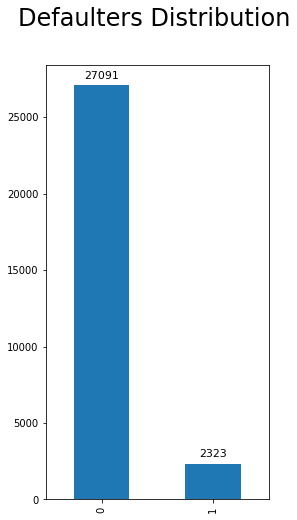

In [58]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


## Univariate analysis

### Continuous Features - Univariate & Segmented Univariate Analysis

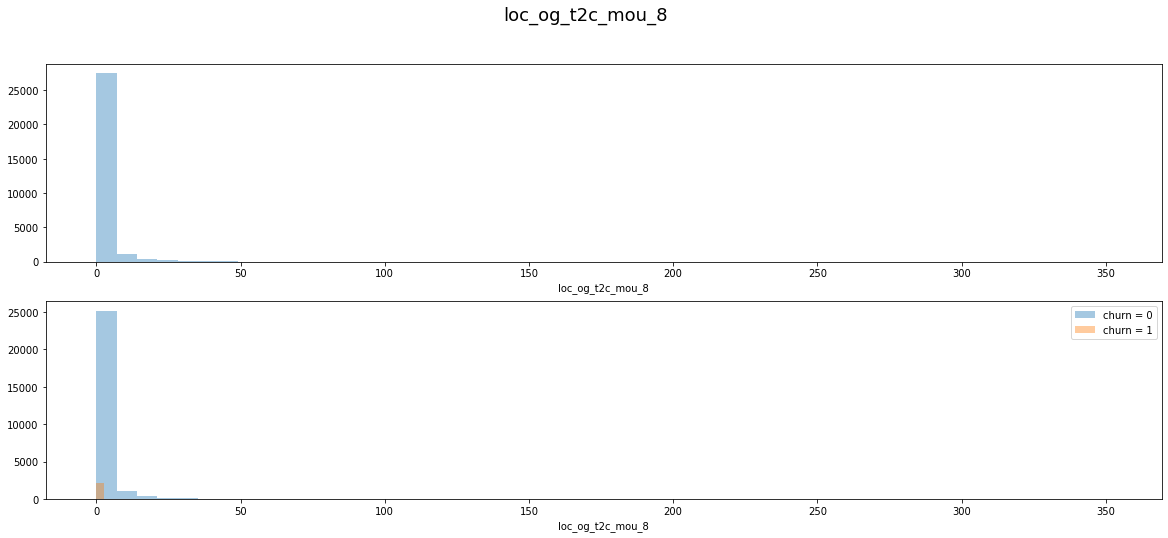

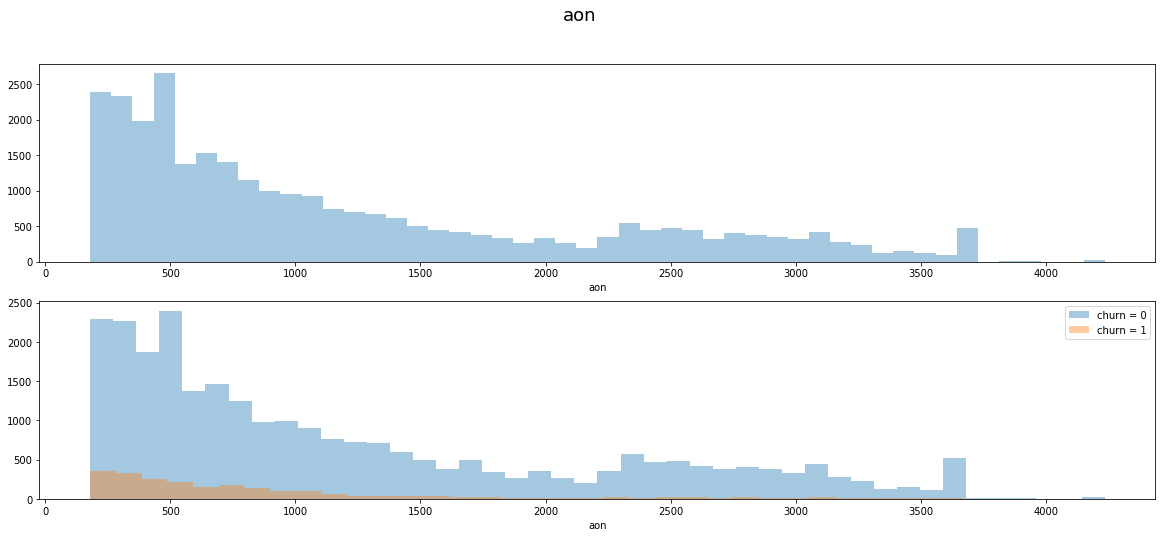

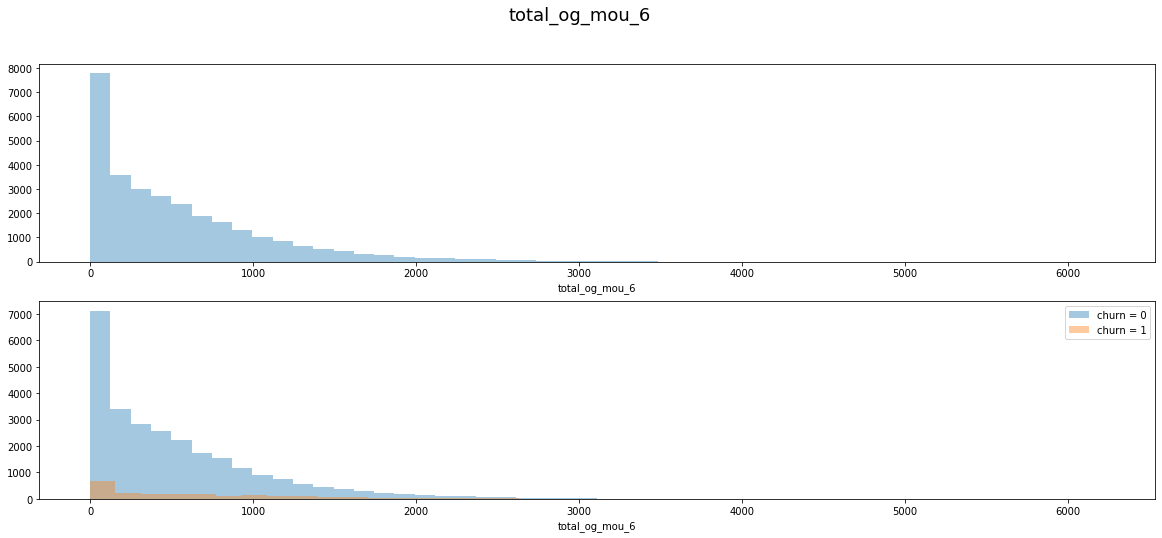

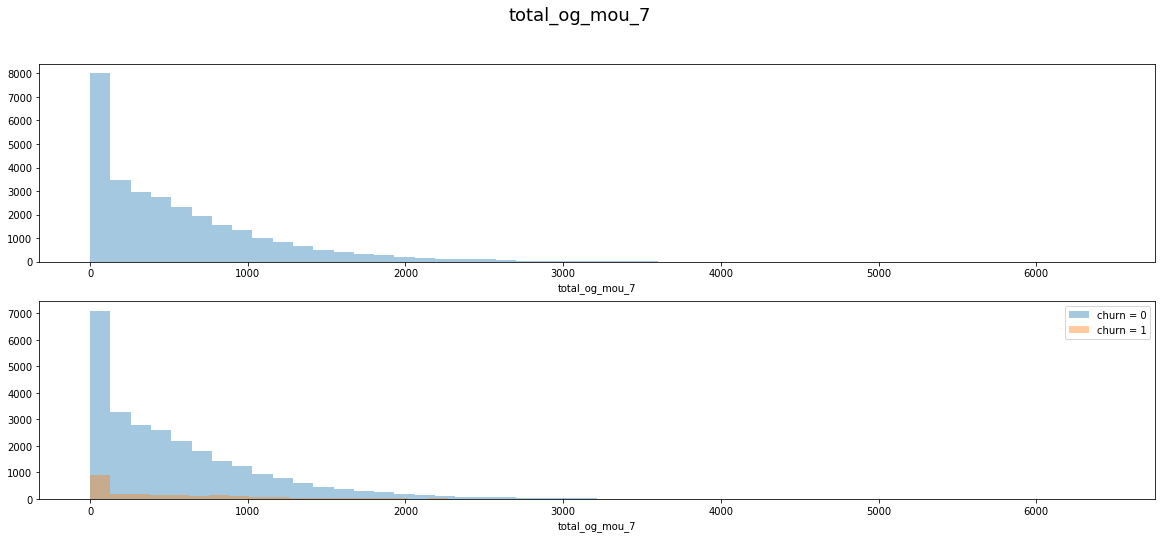

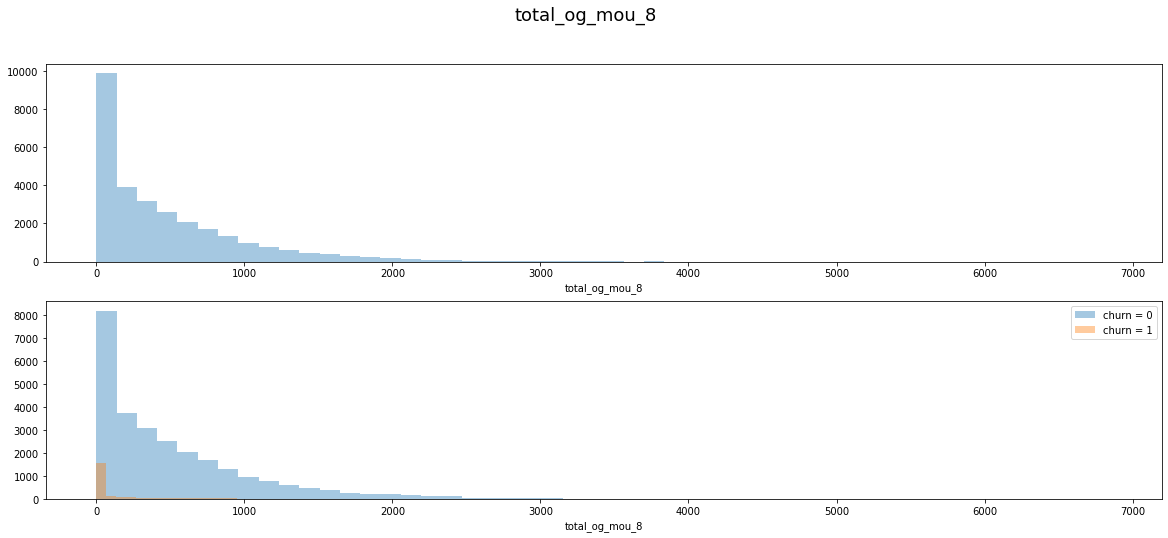

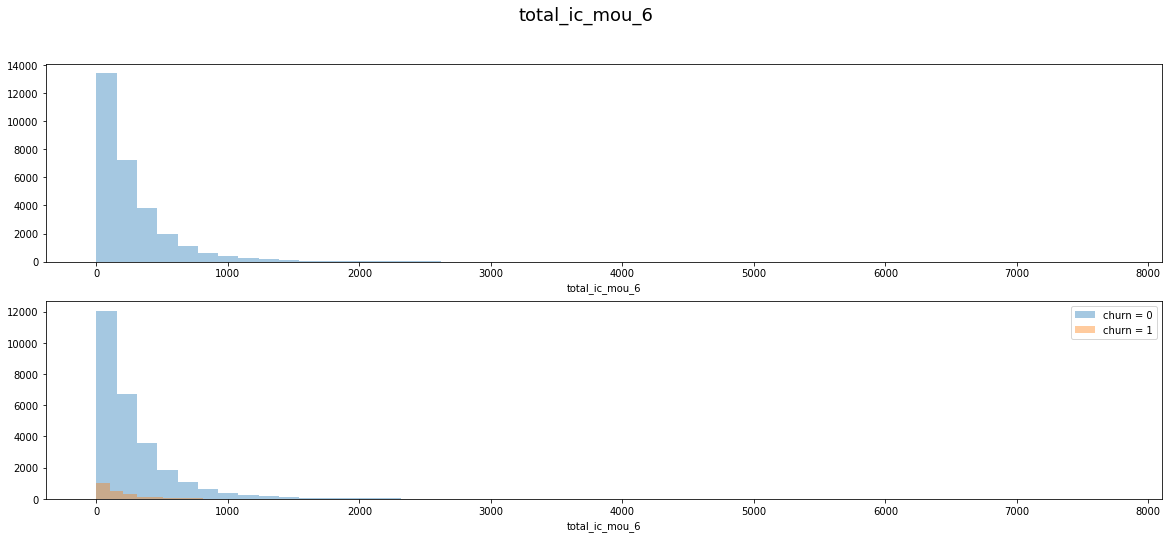

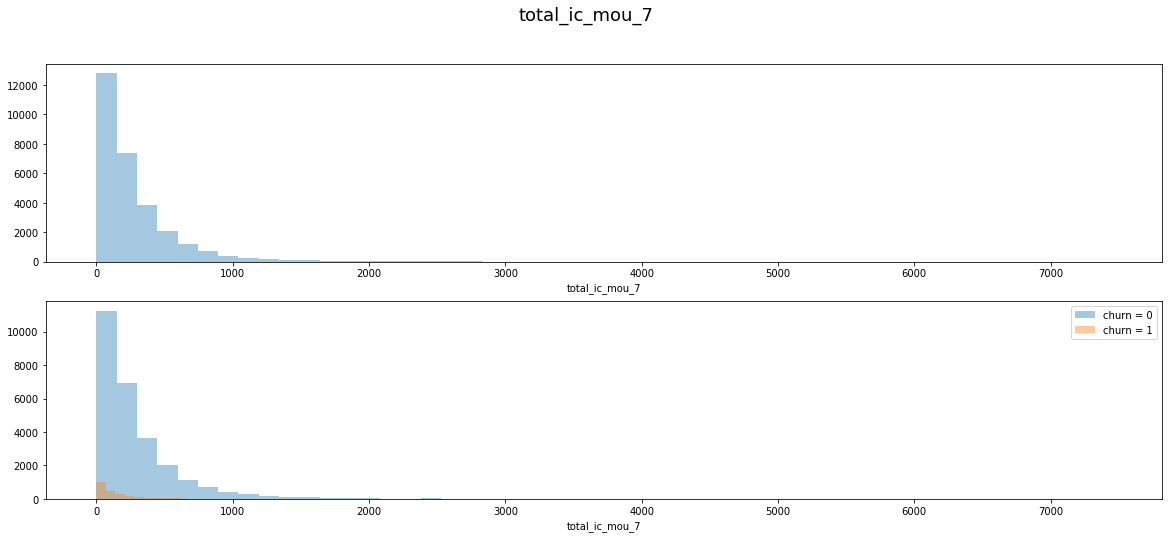

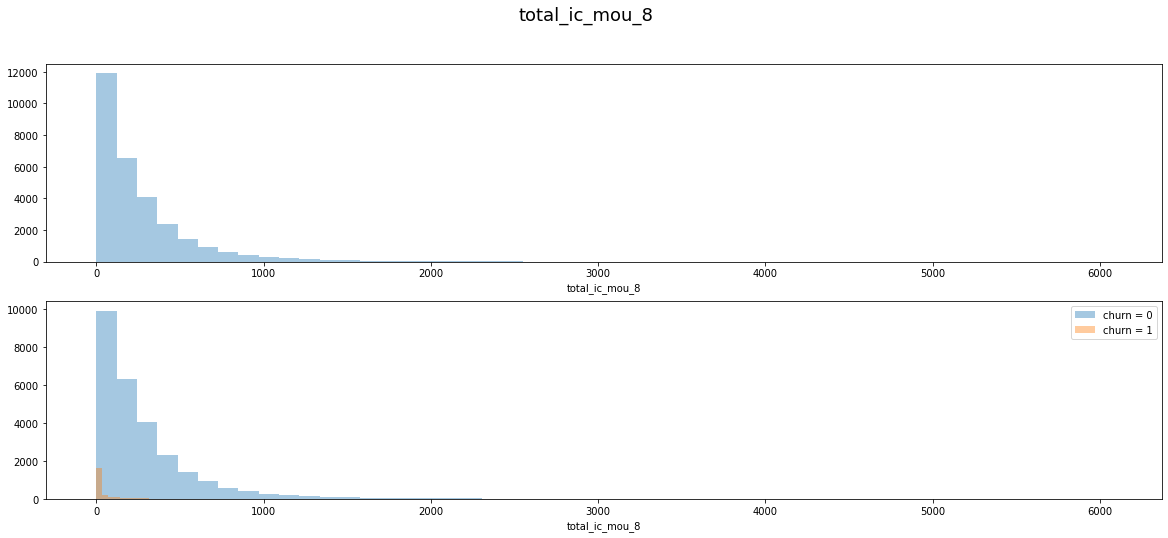

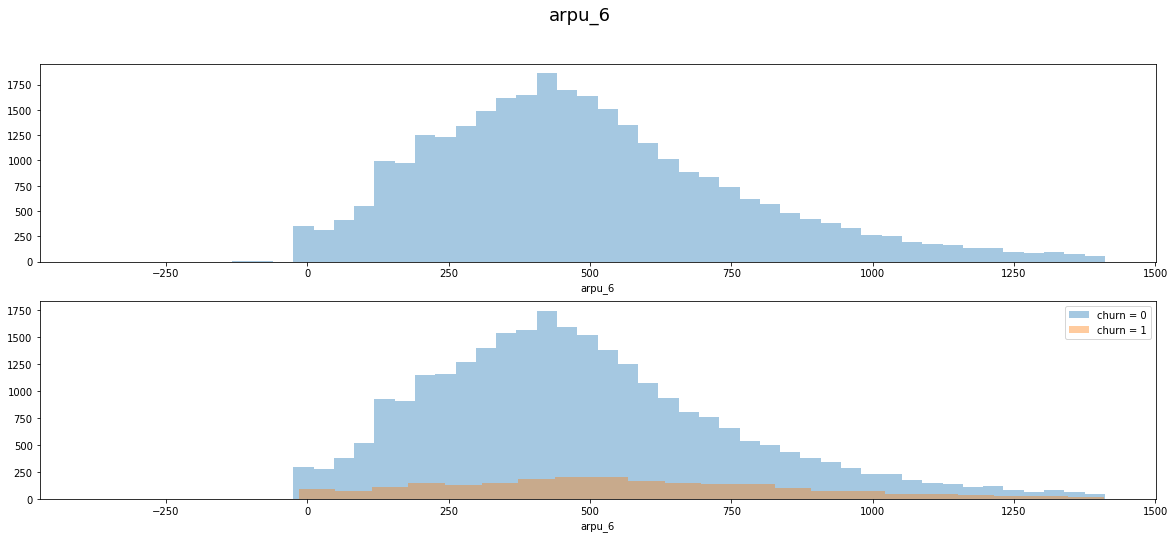

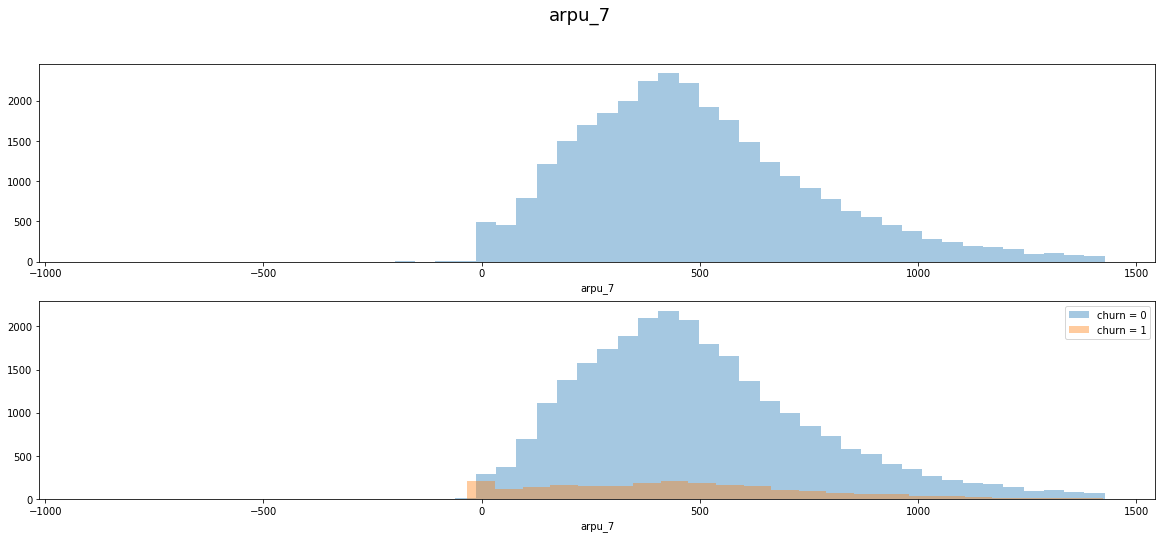

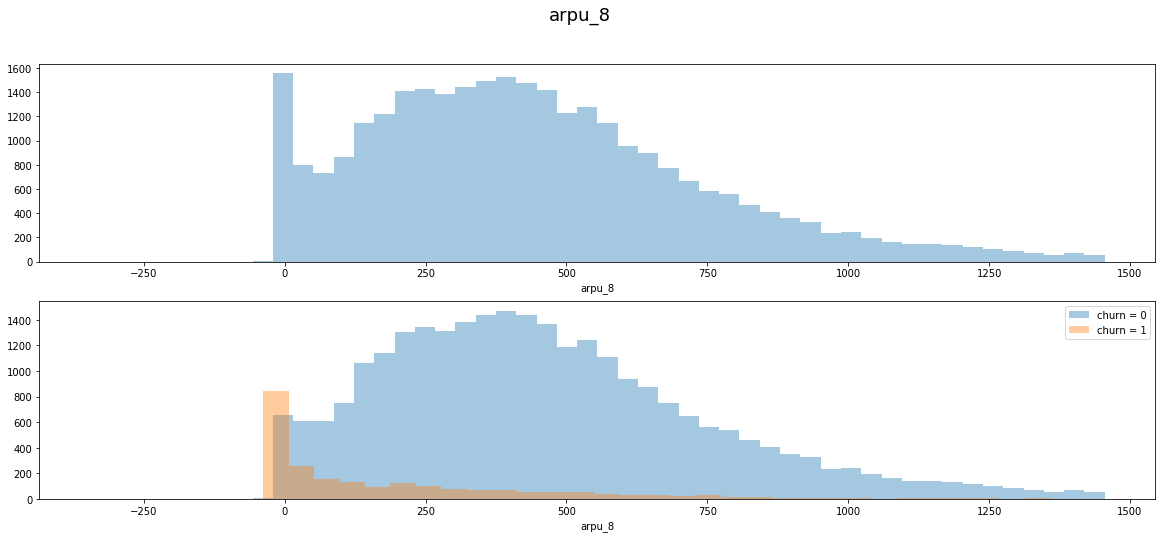

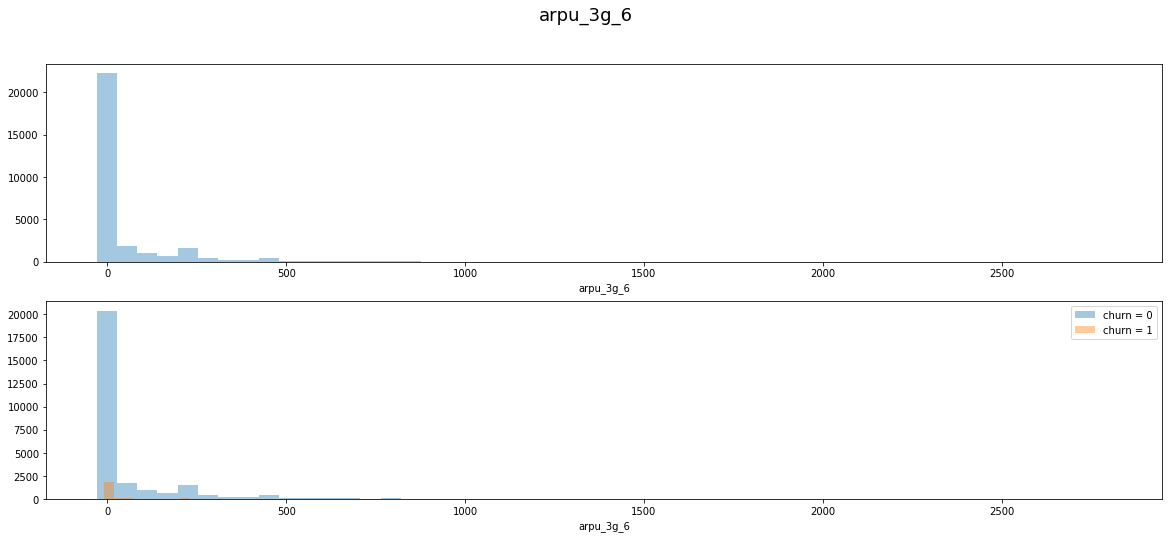

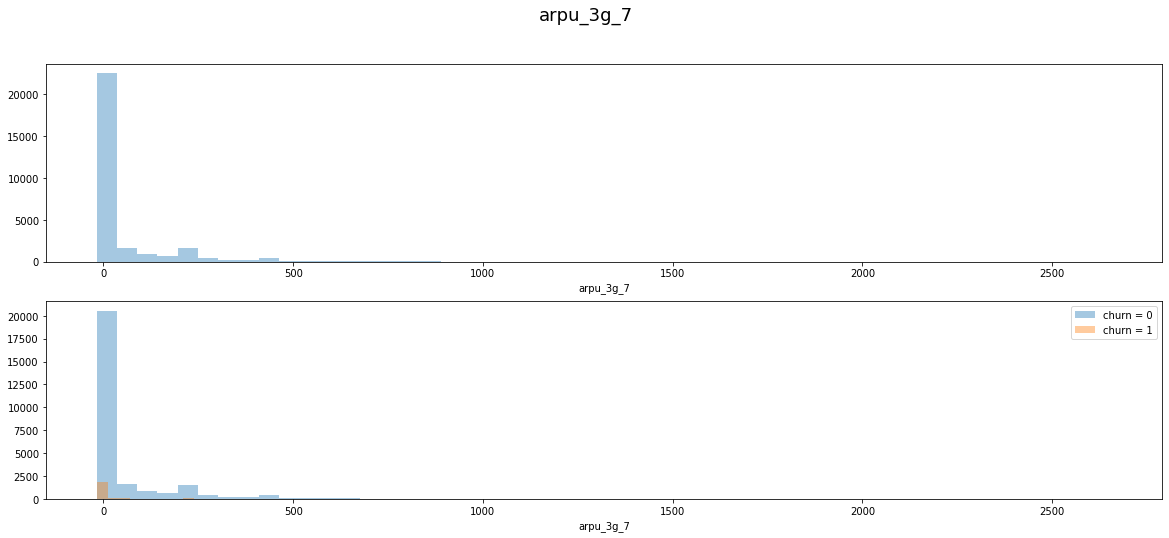

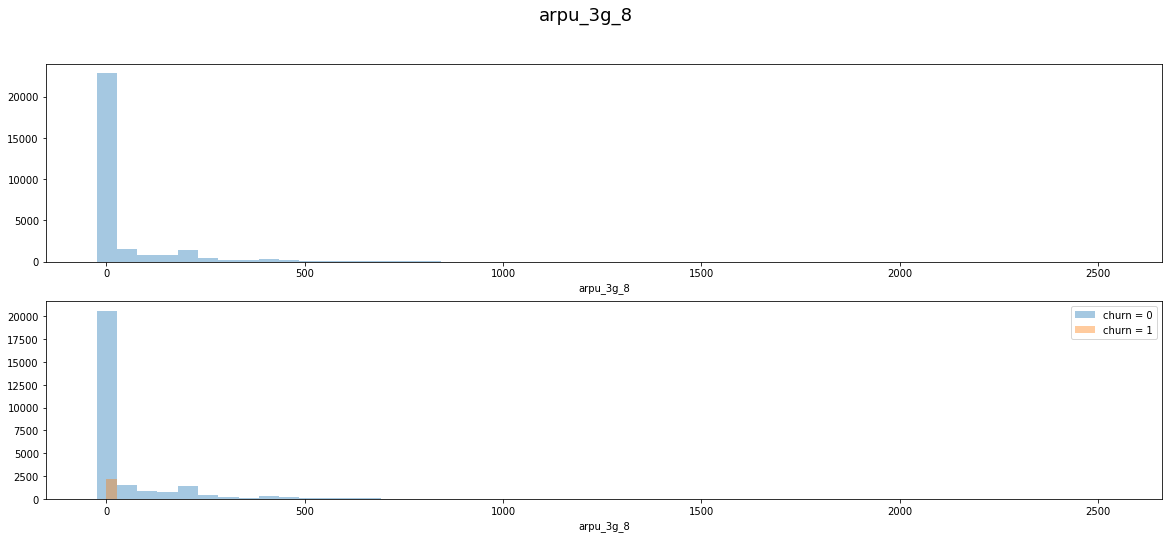

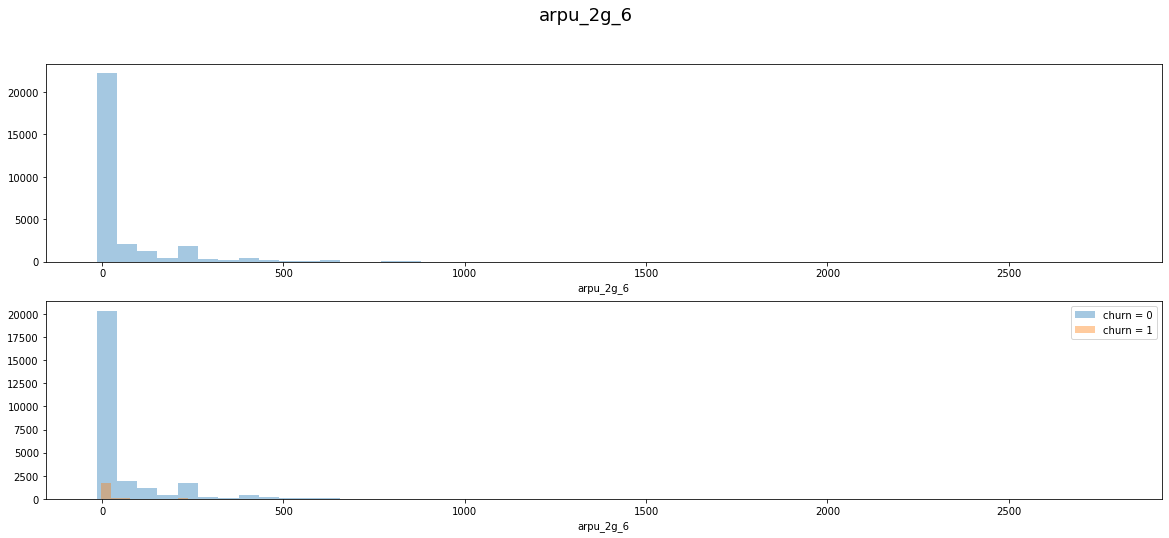

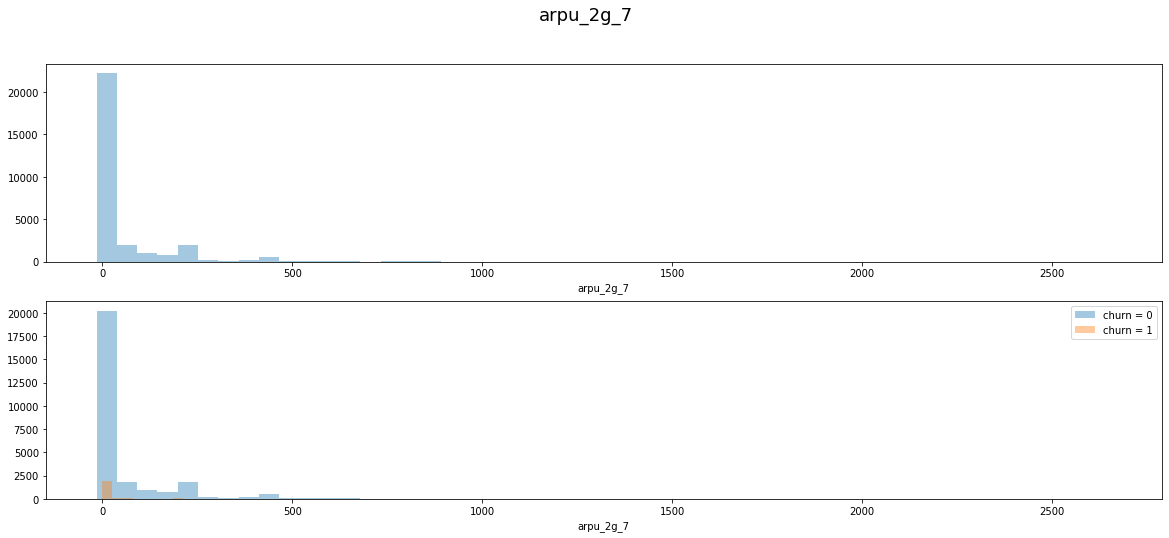

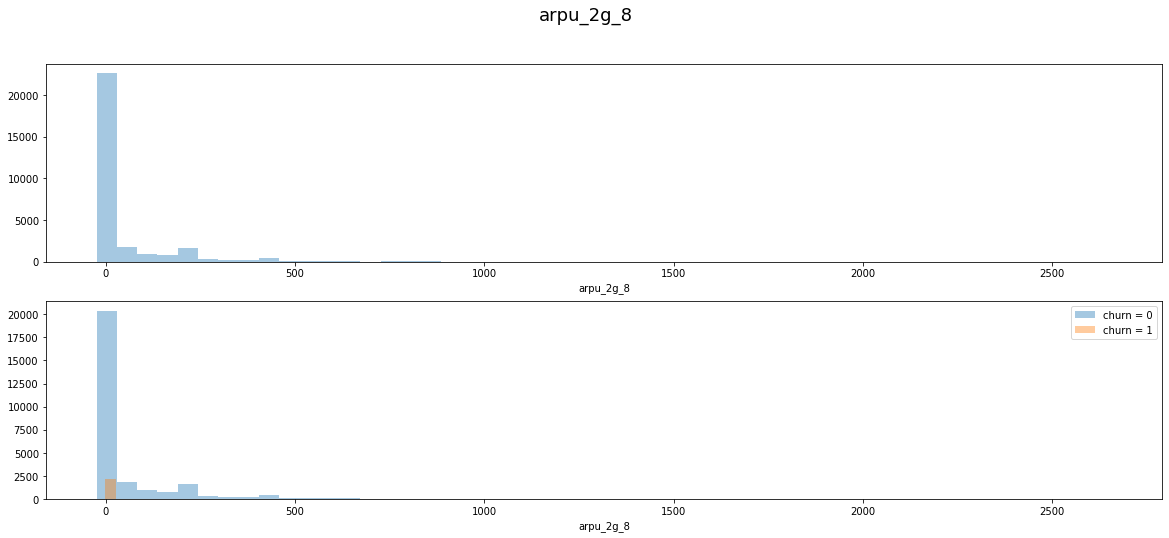

In [59]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [60]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

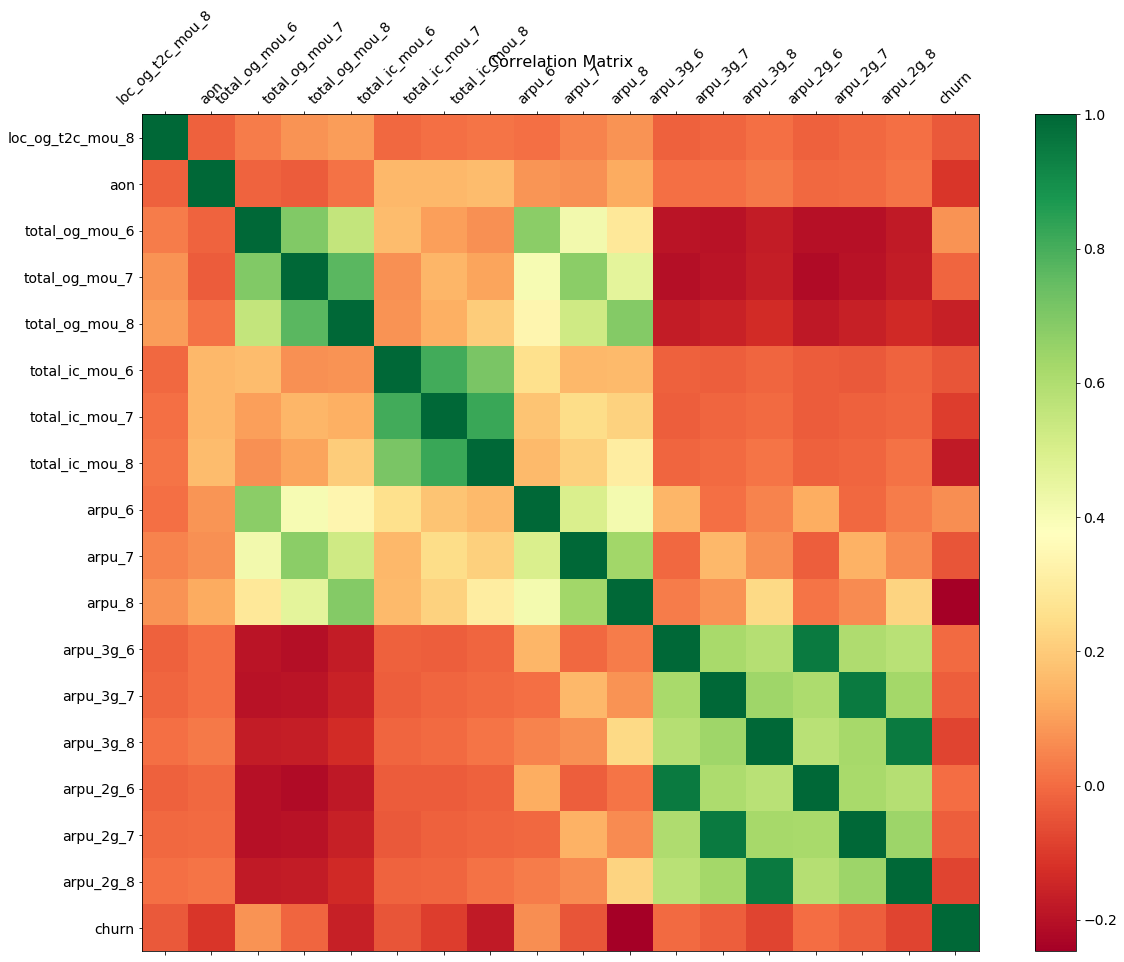

In [61]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [62]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

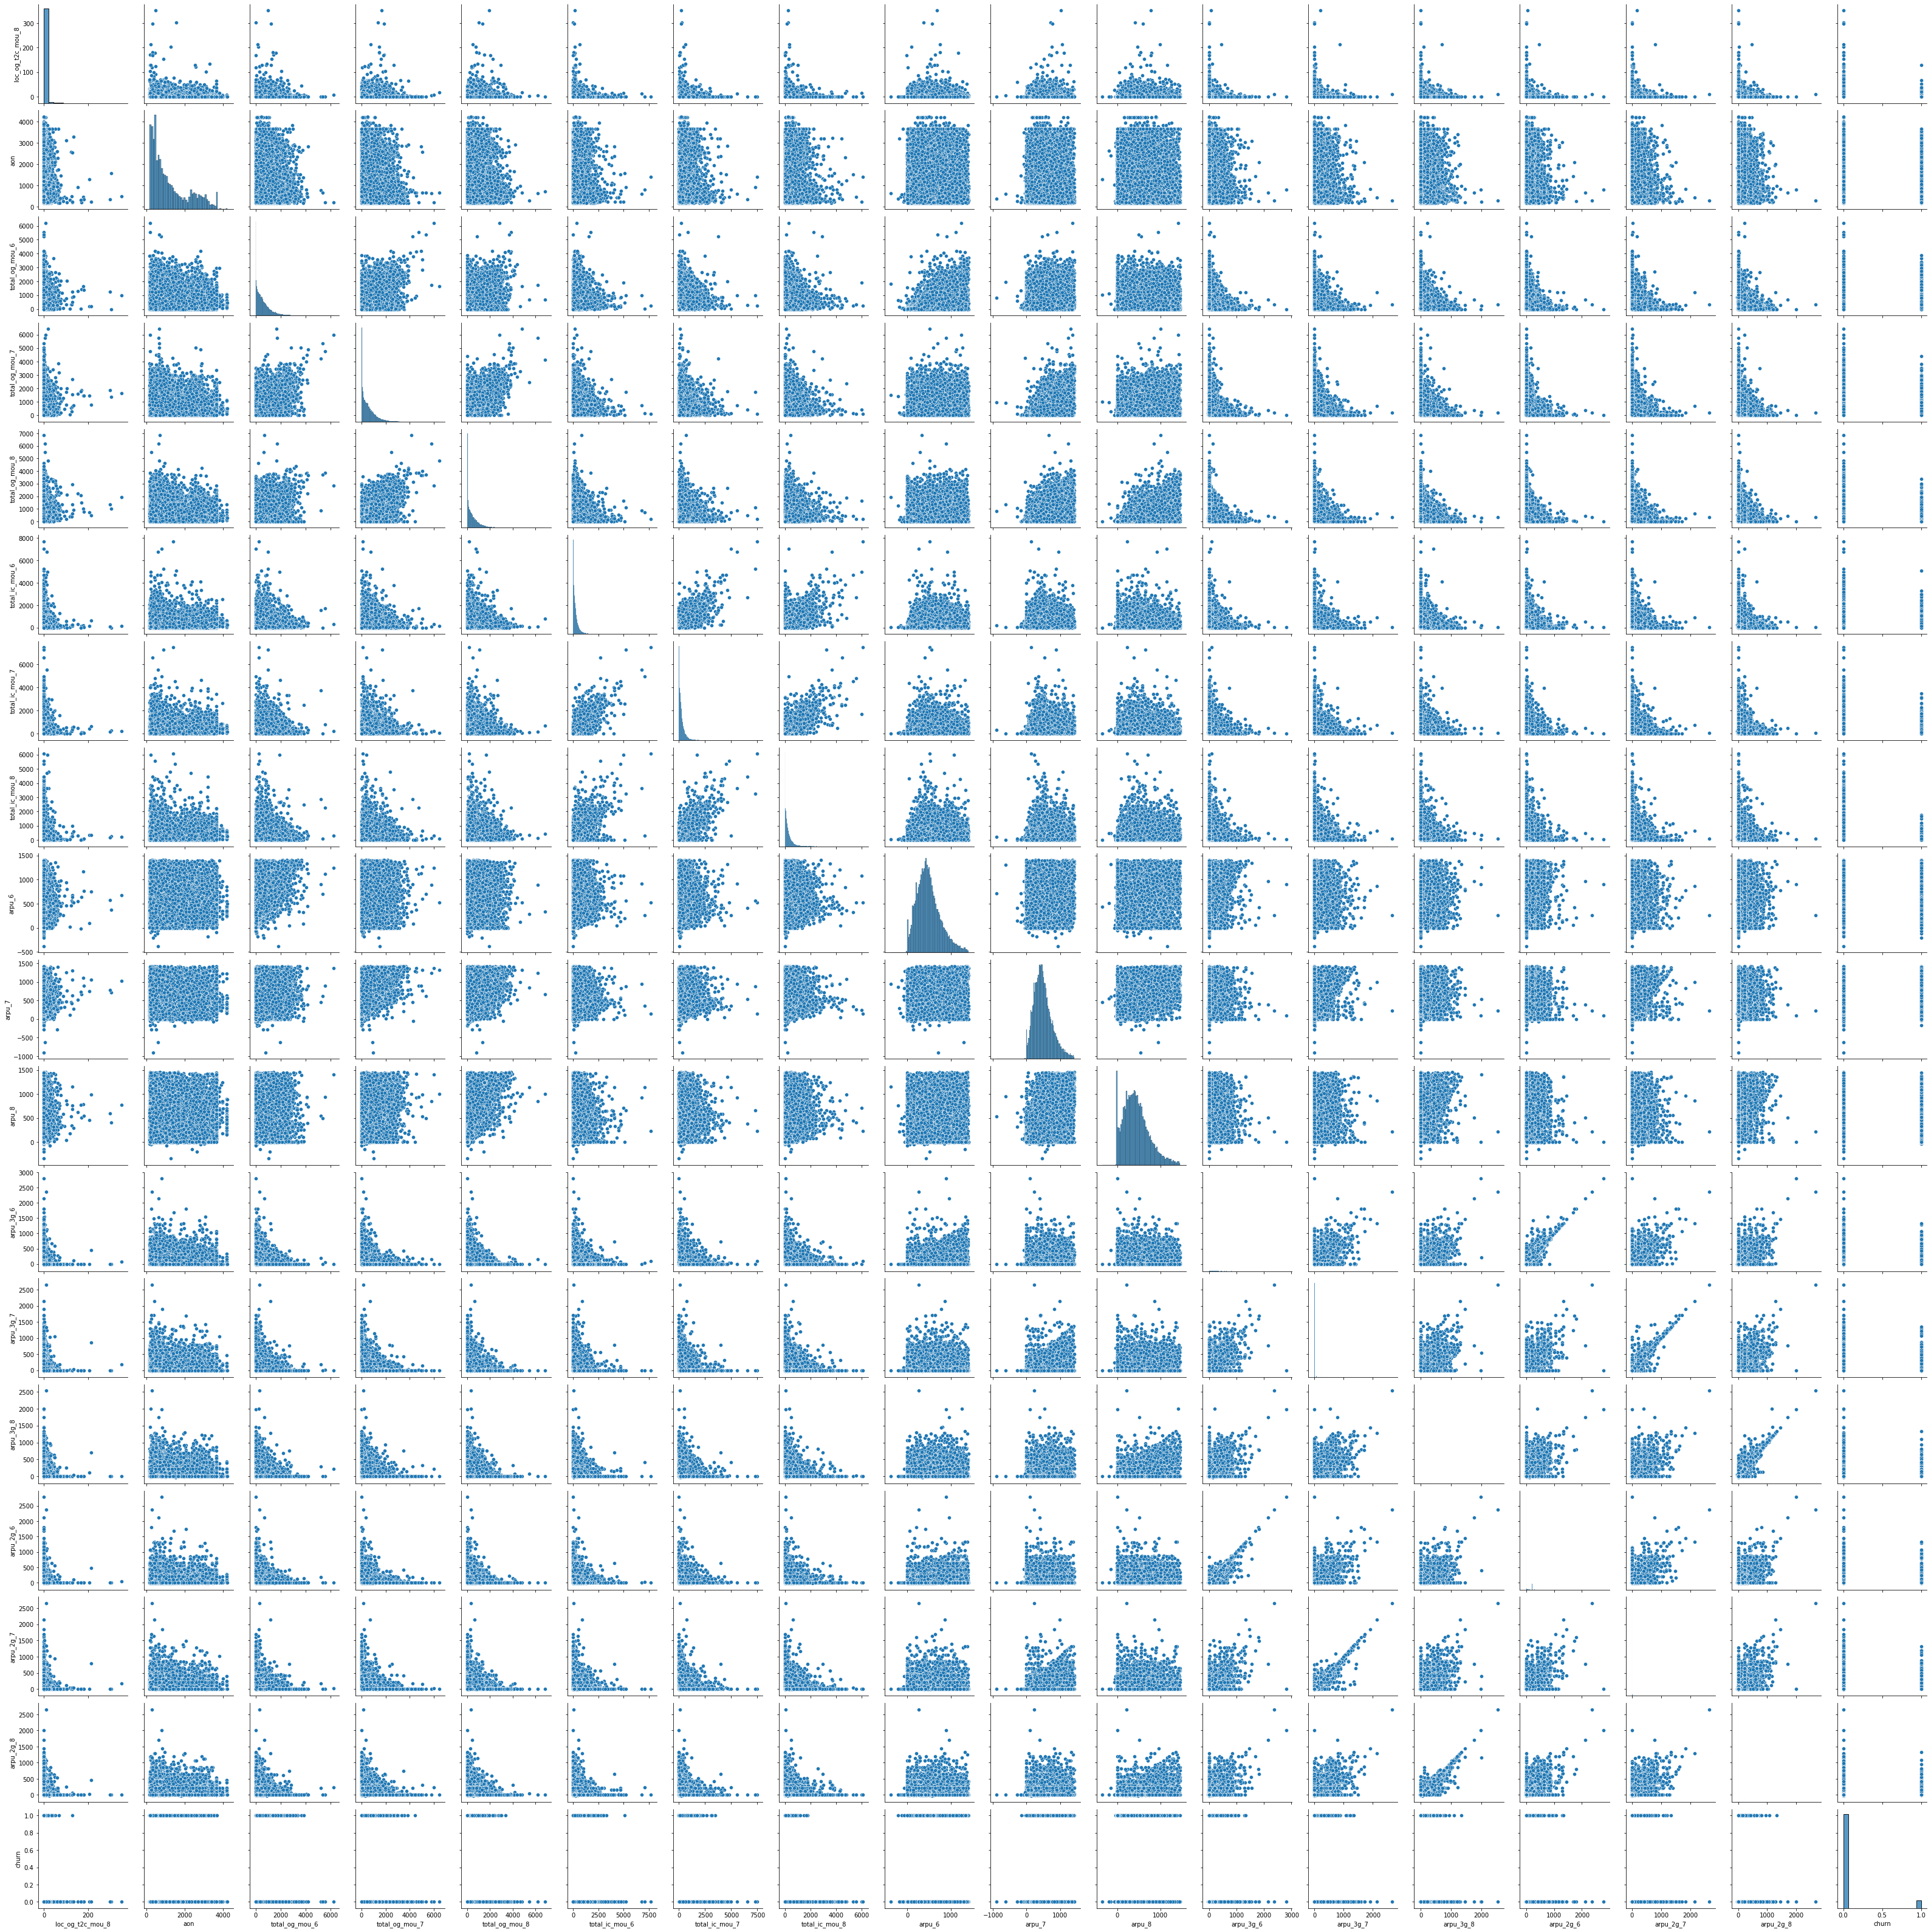

In [63]:
sns.pairplot(df)

<TODO> Insights:
    High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
    Good correlation between alternate months (M6 & M8)<br>
--     Churn is negatively correlated to the calls made to the customer care (t2c). More calls to customer care implies more chances of churning.

# Derive new features

- Derive new feature on average usage in good & action phase 
- Derive new feature on usage during action phase vs good phase

In [64]:
# Method to create the derived features for the given column pattern
# 1. Creates two derived features - average of 3 months, good vs action phase
# 2. Drops the features from which the new columns were created to remove multicollinearity
def create_derived_avg_variables(pattern,col_prefix):
   # Create columns for the good phase & action phase
    gphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_6|_7]$', col)]
    aphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_8]$', col)]

    # Get average for 3 months
    cust[f'{col_prefix}_avg'] = round((cust[gphase_cols].sum(axis=1)+cust[aphase_cols].sum(axis=1))/3,2)

    # Get the differece between action phase & average value in good phase
    # Hypothesis: If the values are in negative, it implies that the variable has reduced in the action phase as compared to an average in the good phase - more likely to churn
    cust[f'{col_prefix}_gaphase_avg'] = round(cust[aphase_cols].sum(axis=1) - (cust[gphase_cols].sum(axis=1))/2,2) 
    
    # Verify Values
    print('Sample data for cross-verification:')
    display(cust[gphase_cols + aphase_cols +[f'{col_prefix}_avg',f'{col_prefix}_gaphase_avg']].tail())
    
    # Drop monthly arpu related columns after creating the derived variables
    cust.drop(gphase_cols, axis=1, inplace=True)
    cust.drop(aphase_cols, axis=1, inplace=True)

In [65]:
cust.shape

(29414, 155)

## Derive based on ARPU (Average Revenue Per User)

In [66]:
create_derived_avg_variables('^arpu_.*','arpu')

Sample data for cross-verification:


arpu_6   arpu_7  arpu_3g_6  arpu_3g_7  arpu_2g_6  arpu_2g_7   arpu_8  \
99981  384.316  255.405     212.18     212.18     212.17     212.17  393.474   
99984  328.594  202.966       0.00       0.00       0.02       8.43  118.707   
99986  644.973  455.228       0.88       0.02       0.00       0.00  564.334   
99988  312.558  512.932       0.00       0.00       0.00       0.00  402.080   
99997  322.991  303.386     235.68     301.34     235.68     301.34  606.817   

       arpu_3g_8  arpu_2g_8  arpu_avg  arpu_gaphase_avg  
99981     212.20     212.17    768.76             73.63  
99984       0.00       6.23    221.65           -145.07  
99986       0.05       0.00    555.16             13.83  
99988       5.44       0.00    411.00             -5.23  
99997     602.68     602.68   1170.86            961.97

## Derive based on total MOU (Minutes of Usage)

In [67]:
create_derived_avg_variables('^total.*mou_','total_mou')

Sample data for cross-verification:


total_og_mou_6  total_og_mou_7  total_ic_mou_6  total_ic_mou_7  \
99981          134.81           57.14          478.48          344.78   
99984          464.58          221.64           89.48          123.71   
99986         1600.79         1183.21          580.73          622.28   
99988          375.78          451.48          998.96          374.98   
99997            0.00            0.00            0.81           11.09   

       total_og_mou_8  total_ic_mou_8  total_mou_avg  total_mou_gaphase_avg  
99981          164.69          420.46         533.45                  77.54  
99984           23.98          102.81         342.07                -322.92  
99986         1380.01          660.01        2009.01                  46.51  
99988          250.79         1233.83        1228.61                 384.02  
99997            0.00            2.29           4.73                  -3.66

## Derive based on volume of data usage

In [68]:
create_derived_avg_variables('^vol_.*','vol')

Sample data for cross-verification:


vol_2g_mb_6  vol_2g_mb_7  vol_3g_mb_6  vol_3g_mb_7  vol_2g_mb_8  \
99981        54.81       101.02       692.72       596.91       112.07   
99984      1248.50       725.05         0.00         0.00       202.22   
99986        34.28        16.41       736.01      1129.34         6.47   
99988         0.00         0.00         0.00        13.56         0.79   
99997        76.51       241.77      1453.63      1382.08       136.47   

       vol_3g_mb_8  vol_avg  vol_gaphase_avg  
99981      1012.70   856.74           402.04  
99984         0.00   725.26          -784.56  
99986       926.78   949.76           -24.77  
99988       678.74   231.03           672.75  
99997      2683.30  1991.25          1242.78

## Derive based on outgoing calls

In [69]:
# Handle the outgoing calls to customer care separately
create_derived_avg_variables('^loc_og_t2c_mou_','loc_t2c_og')
create_derived_avg_variables('^loc_og_.*','loc_og')

Sample data for cross-verification:


loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_t2c_og_avg  \
99981              3.91              0.00              0.00            1.30   
99984             17.04             15.38              7.28           13.23   
99986             15.96             16.71              9.15           13.94   
99988              0.00              0.00              0.01            0.00   
99997              0.00              0.00              0.00            0.00   

       loc_t2c_og_gaphase_avg  
99981                   -1.96  
99984                   -8.93  
99986                   -7.18  
99988                    0.01  
99997                    0.00

Sample data for cross-verification:


loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
99981             72.53             29.04             52.21             20.89   
99984            423.99            181.83             17.96             20.46   
99986            709.21            496.14            574.93            546.84   
99988            170.28            146.48            137.83            148.78   
99997              0.00              0.00              0.00              0.00   

       loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_mou_6  loc_og_mou_7  \
99981              0.00              0.00        124.74         49.94   
99984              0.00              0.00        441.96        202.29   
99986             16.28             19.48       1300.43       1062.48   
99988              0.00              0.00        308.11        295.26   
99997              0.00              0.00          0.00          0.00   

       loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_mou_8  \
99981             89.23             55.59              5.76        150.59   
99984              5.71             10.98              0.00         16.69   
99986            718.56            493.48             13.01       1225.06   
99988              2.46            128.01              0.00        130.48   
99997              0.00              0.00              0.00          0.00   

       loc_og_avg  loc_og_gaphase_avg  
99981      216.84              126.49  
99984      440.62             -610.86  
99986     2391.97               87.21  
99988      489.23             -342.42  
99997        0.00                0.00

## Derive based on incoming calls

In [70]:
create_derived_avg_variables('^loc_ic_.*','loc_ic')

Sample data for cross-verification:


loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
99981            285.33            264.44             93.36             61.56   
99984             32.21             45.14             53.49             76.76   
99986            140.71            104.04            395.58            475.33   
99988             47.56              3.90            245.31            256.46   
99997              0.00              0.70              0.81             10.39   

       loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_mou_6  loc_ic_mou_7  \
99981              0.30             11.26        378.99        337.28   
99984              0.00              0.00         85.71        121.91   
99986             29.96             38.69        566.26        618.08   
99988             14.43             28.39        307.31        288.76   
99997              0.00              0.00          0.81         11.09   

       loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
99981            303.61             58.54             40.41        402.58   
99984             20.94             81.86              0.00        102.81   
99986            148.21            450.01             37.61        635.84   
99988              1.50           1122.83             20.31       1144.64   
99997              0.00              1.71              0.00          1.71   

       loc_ic_avg  loc_ic_gaphase_avg  
99981      745.89               88.88  
99984      206.94               -2.00  
99986     1213.44               87.35  
99988     1160.47             1693.22  
99997        9.07               -8.48

In [71]:
cust.shape

(29414, 119)

## Derive for the roaming calls

In [72]:
create_derived_avg_variables('^roam_.*_mou_','roam_mou')

Sample data for cross-verification:


roam_ic_mou_6  roam_ic_mou_7  roam_og_mou_6  roam_og_mou_7  \
99981            0.0            0.0            0.0            0.0   
99984            0.0            0.0            0.0            0.0   
99986            0.0            0.0            0.0            0.0   
99988            0.0            0.0            0.0            0.0   
99997            0.0            0.0            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_8  roam_mou_avg  roam_mou_gaphase_avg  
99981            0.0            0.0           0.0                   0.0  
99984            0.0            0.0           0.0                   0.0  
99986            0.0            0.0           0.0                   0.0  
99988            0.0            0.0           0.0                   0.0  
99997            0.0            0.0           0.0                   0.0

## Dervice for recharge amount and drop the other rech columns

In [73]:
cust['total_rech_data_amt_6'] = cust['total_rech_data_6']*cust['av_rech_amt_data_6']
cust['total_rech_data_amt_7'] = cust['total_rech_data_7']*cust['av_rech_amt_data_7']
cust['total_rech_data_amt_8'] = cust['total_rech_data_8']*cust['av_rech_amt_data_8']
cust.drop(['total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_data_8','av_rech_amt_data_8'],axis=1,inplace=True)

In [74]:
create_derived_avg_variables('^total_rech_.*amt_','total_rech_amt')
create_derived_avg_variables('^count_rech_.*g_','count_rech')
create_derived_avg_variables('^total_rech_num_','total_rech_num')
create_derived_avg_variables('^max_rech_amt_','max_rech_amt')
create_derived_avg_variables('^max_rech_data_','max_rech_data')
create_derived_avg_variables('^last_day_rch_amt_','last_day_rch_amt')


Sample data for cross-verification:


total_rech_amt_6  total_rech_amt_7  total_rech_data_amt_6  \
99981               252               372                  252.0   
99984               360               239                  154.0   
99986               567              1130                   17.0   
99988               380               554                    0.0   
99997               381               358                 1749.0   

       total_rech_data_amt_7  total_rech_amt_8  total_rech_data_amt_8  \
99981                  252.0               512                  252.0   
99984                  484.0               137                  585.0   
99986                   14.0                25                   25.0   
99988                  154.0               504                  154.0   
99997                  716.0               716                 2864.0   

       total_rech_amt_avg  total_rech_amt_gaphase_avg  
99981              630.67                       200.0  
99984              653.00                       103.5  
99986              592.67                      -814.0  
99988              582.00                       114.0  
99997             2261.33                      1978.0

Sample data for cross-verification:


count_rech_2g_6  count_rech_2g_7  count_rech_3g_6  count_rech_3g_7  \
99981              0.0              0.0              1.0              1.0   
99984              1.0              4.0              0.0              0.0   
99986              1.0              1.0              0.0              0.0   
99988              0.0              1.0              0.0              0.0   
99997              1.0              0.0              2.0              2.0   

       count_rech_2g_8  count_rech_3g_8  count_rech_avg  \
99981              0.0              1.0            1.00   
99984              5.0              0.0            3.33   
99986              1.0              0.0            1.00   
99988              1.0              0.0            0.67   
99997              0.0              4.0            3.00   

       count_rech_gaphase_avg  
99981                     0.0  
99984                     2.5  
99986                     0.0  
99988                     0.5  
99997                     1.5

Sample data for cross-verification:


total_rech_num_6  total_rech_num_7  total_rech_num_8  \
99981                 2                 4                 3   
99984                 8                10                 9   
99986                 6                 8                 3   
99988                12                12                 9   
99997                 3                 4                 4   

       total_rech_num_avg  total_rech_num_gaphase_avg  
99981                3.00                         0.0  
99984                9.00                         0.0  
99986                5.67                        -4.0  
99988               11.00                        -3.0  
99997                3.67                         0.5

Sample data for cross-verification:


max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  max_rech_amt_avg  \
99981             252             252             252            252.00   
99984             154              46              30             76.67   
99986             550             786              25            453.67   
99988              50             154             154            119.33   
99997             202             179             179            186.67   

       max_rech_amt_gaphase_avg  
99981                       0.0  
99984                     -70.0  
99986                    -643.0  
99988                      52.0  
99997                     -11.5

Sample data for cross-verification:


max_rech_data_6  max_rech_data_7  max_rech_data_8  max_rech_data_avg  \
99981            252.0            252.0            252.0             252.00   
99984            154.0             46.0             25.0              75.00   
99986             17.0             14.0             25.0              18.67   
99988              0.0            154.0            154.0             102.67   
99997            202.0            179.0            179.0             186.67   

       max_rech_data_gaphase_avg  
99981                        0.0  
99984                      -75.0  
99986                        9.5  
99988                       77.0  
99997                      -11.5

Sample data for cross-verification:


last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
99981                 252                   0                 130   
99984                   0                  25                  25   
99986                 550                 786                   0   
99988                  50                  50                  50   
99997                 202                 179                 179   

       last_day_rch_amt_avg  last_day_rch_amt_gaphase_avg  
99981                127.33                           4.0  
99984                 16.67                          12.5  
99986                445.33                        -668.0  
99988                 50.00                           0.0  
99997                186.67                         -11.5

## Derive for std incoming & outgoing

In [75]:
create_derived_avg_variables('^std_og_.*','std_og')
create_derived_avg_variables('^std_ic_.*','std_ic')

Sample data for cross-verification:


std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2m_mou_6  std_og_t2m_mou_7  \
99981              6.15              0.00              0.00              0.00   
99984              0.00              0.00              0.03              3.96   
99986             97.51             53.21            186.88             50.79   
99988             29.61             27.98             38.04            128.23   
99997              0.00              0.00              0.00              0.00   

       std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_mou_6  std_og_mou_7  \
99981               0.0               0.0          6.15          0.00   
99984               0.0               0.0          0.03          3.96   
99986               0.0               0.0        284.39        104.01   
99988               0.0               0.0         67.66        156.21   
99997               0.0               0.0          0.00          0.00   

       std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  std_og_mou_8  \
99981             14.01              0.00               0.0         14.01   
99984              0.00              0.00               0.0          0.00   
99986             56.84             88.94               0.0        145.79   
99988              0.00            120.29               0.0        120.29   
99997              0.00              0.00               0.0          0.00   

       std_og_avg  std_og_gaphase_avg  
99981       13.44               21.87  
99984        2.66               -3.99  
99986      356.12              -96.82  
99988      229.44               16.72  
99997        0.00                0.00

Sample data for cross-verification:


std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2m_mou_6  std_ic_t2m_mou_7  \
99981             57.60              0.91              0.00              0.00   
99984              0.00              0.00              2.33              0.75   
99986              2.31              0.00             12.14              1.03   
99988             10.08             13.21            680.34             72.99   
99997              0.00              0.00              0.00              0.00   

       std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_mou_6  std_ic_mou_7  \
99981             41.59              6.51         99.19          7.43   
99984              0.99              1.04          3.33          1.79   
99986              0.00              2.73         14.46          3.76   
99988              1.01              0.00        691.44         86.21   
99997              0.00              0.00          0.00          0.00   

       std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
99981             17.36              0.00              0.00         17.36   
99984              0.00              0.00              0.00          0.00   
99986              0.00             23.71              0.45         24.16   
99988              2.03             86.11              0.71         88.86   
99997              0.00              0.58              0.00          0.58   

       std_ic_avg  std_ic_gaphase_avg  
99981       82.65              -71.90  
99984        3.41               -5.12  
99986       28.25               30.10  
99988      577.66             -599.93  
99997        0.39                1.16

In [76]:
[col for col in cust.columns if re.search(f'last_day_rch_amt', col)]

['last_day_rch_amt_avg', 'last_day_rch_amt_gaphase_avg']

In [77]:
# TO ADD

In [78]:
[col for col in cust.columns if re.search(f'rech', col)]

['last_rech_num_days',
 'avg_rech_amt_6_7',
 'total_rech_amt_avg',
 'total_rech_amt_gaphase_avg',
 'count_rech_avg',
 'count_rech_gaphase_avg',
 'total_rech_num_avg',
 'total_rech_num_gaphase_avg',
 'max_rech_amt_avg',
 'max_rech_amt_gaphase_avg',
 'max_rech_data_avg',
 'max_rech_data_gaphase_avg']

In [79]:
cust.shape

(29414, 80)

In [80]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  29414.000000  29414.000000  29414.000000  29414.000000  29414.000000   
mean     236.100687    240.010311    207.843448    330.006015    331.750852   
std      392.280177    405.171153    376.709715    383.768040    391.877998   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
5%         0.000000      0.000000      0.000000      0.186500      0.000000   
10%        0.580000      0.466000      0.000000     10.640000      9.690000   
25%       16.040000     14.910000      9.640000     66.830000     65.210000   
50%       79.745000     77.000000     60.735000    207.735000    203.385000   
75%      270.422500    267.685000    221.090000    448.852500    453.462500   
90%      695.392000    714.068000    606.935000    800.424000    817.872000   
95%     1049.075500   1070.780500    966.358000   1091.908500   1103.210500   
99%     1868.322000   1898.788700   1827.626700   1836.084500   1837.898600   
max     6109.080000   6372.530000   6723.790000   3591.940000   3739.730000   

       offnet_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
count  29414.000000  29414.000000  29414.000000  29414.000000  29414.000000   
mean     292.256447      0.853711      0.765015      0.673242      5.479718   
std      366.641757     10.059625      8.262198      9.107340     15.571254   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
1%         0.000000      0.000000      0.000000      0.000000      0.000000   
5%         0.000000      0.000000      0.000000      0.000000      0.000000   
10%        2.016000      0.000000      0.000000      0.000000      0.000000   
25%       43.115000      0.000000      0.000000      0.000000      0.000000   
50%      169.090000      0.000000      0.000000      0.000000      0.180000   
75%      402.170000      0.000000      0.000000      0.000000      4.960000   
90%      733.738000      0.000000      0.000000      0.000000     15.447000   
95%     1012.019500      0.400000      0.330000      0.110000     25.593500   
99%     1740.565000     18.179300     17.703500     11.429600     63.227400   
max     3676.110000    723.640000    364.090000    601.310000    811.860000   

       ...  max_rech_amt_avg  max_rech_amt_gaphase_avg  max_rech_data_avg  \
count  ...      29414.000000              29414.000000       29414.000000   
mean   ...        154.340132                -10.369637          72.435295   
std    ...        115.322797                116.887140          91.220723   
min    ...          0.000000              -1675.000000           0.000000   
1%     ...         22.042900               -475.935000           0.000000   
5%     ...         33.330000               -154.000000           0.000000   
10%    ...         48.670000               -103.000000           0.000000   
25%    ...         90.000000                -32.000000           0.000000   
50%    ...        128.000000                  0.000000          25.000000   
75%    ...        183.670000                 24.000000         134.670000   
90%    ...        258.000000                 66.000000         192.000000   
95%    ...        356.785500                105.000000         252.000000   
99%    ...        599.625800                275.000000         335.495800   
max    ...       3332.330000               3949.000000        1555.000000   

       max_rech_data_gaphase_avg  last_day_rch_amt_avg  \
count               29414.000000          29414.000000   
mean                   -6.339719             90.103607   
std                    73.611499             86.023701   
min                  -951.000000              0.000000   
1%                   -252.000000              0.000000   
5%                   -137.000000             10.000000   
10%                   -78.500000             16.670000   
25%             

# Split data to independent & dependent variables

In [81]:
X = cust.drop([DEPENDENT_VARIABLE],axis=1)
y = cust[DEPENDENT_VARIABLE]

# Handle class imbalance

In [82]:
cust['churn'].value_counts()

0    27091
1     2323
Name: churn, dtype: int64

<font color='green'>
    <b>Observations on class imbalance:</b><br>
- In the given dataset, churn vs non-churn is at 10%-90%. <br>
- This is a case of class imbalance where one class outnumbers the other. <br>
- We can apply some of the class imbalance techniques to address this issue and observe how the models behave <br>
- In this case study we shall use the oversampling & SMOTE techniques to address the class imbalance issue
</font>

## Oversampling

In [83]:
# import library
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

# fit predictor and target variablex_ros, 
X_oversampled, y_oversampled = over_sampler.fit_resample(X,y)


print(f'''Shape of X before oversampling: {X.shape}
Shape of X after oversampling: {X_oversampled.shape}''')

print('\nBalance of positive and negative classes (%):')
y_oversampled.value_counts(normalize=True) * 100



Shape of X before oversampling: (29414, 79)
Shape of X after oversampling: (54182, 79)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

## SMOTE

In [84]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_smote.value_counts(normalize=True) * 100

Shape of X before SMOTE: (29414, 79)
Shape of X after SMOTE: (54182, 79)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

# Train-test split

## Train-test split on original data (without oversampling or SMOTE)

In [85]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

## Train-test split on oversampled data 


In [86]:
# 70% of data used as train data and the remaining 30% as test data
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled,y_oversampled,test_size = 0.3, random_state=100)

## Train-test split on SMOTE data 


In [87]:
# 70% of data used as train data and the remaining 30% as test data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size = 0.3, random_state=100)

# Feature Scaling

- After the train-test split, the features needs to be scaled as they are of different ranges.  
- Here we will use the MinMaxScaler to scale the data  
- All the 3 sets of data that has been created should be scaled.  
- Scaler should be fit on the training data. Only the transform method needs to be applied on the test data. (To ensure that the min & max values from the train data is used on the test data)

In [88]:
cols_to_scale = X_train.columns

In [89]:
# Scale the original dataset
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale] )

In [90]:
# Scale the oversampled dataset
scaler_os = MinMaxScaler()
X_oversampled_train[cols_to_scale] = scaler_os.fit_transform(X_oversampled_train[cols_to_scale])
X_oversampled_test[cols_to_scale] = scaler_os.transform(X_oversampled_test[cols_to_scale])

In [91]:
# Scale the SMOTE dataset
scaler_smote = MinMaxScaler()
X_smote_train[cols_to_scale] = scaler_smote.fit_transform(X_smote_train[cols_to_scale])
X_smote_test[cols_to_scale] = scaler_smote.transform(X_smote_test[cols_to_scale])

In [92]:
X_train.describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20589.000000  20589.000000  20589.000000  20589.000000  20589.000000   
mean       0.038290      0.037710      0.034777      0.092557      0.089612   
std        0.063238      0.063521      0.062995      0.106773      0.105576   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.002629      0.002363      0.001658      0.018689      0.017632   
50%        0.013125      0.012176      0.010276      0.058481      0.054552   
75%        0.043813      0.041861      0.036892      0.126625      0.122752   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       offnet_mou_8  isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  \
count  20589.000000  20589.000000  20589.000000  20589.000000  20589.000000   
mean       0.082425      0.001165      0.002134      0.001130      0.006791   
std        0.103226      0.014012      0.023296      0.015707      0.020024   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.012337      0.000000      0.000000      0.000000      0.000000   
50%        0.047705      0.000000      0.000000      0.000000      0.000222   
75%        0.113275      0.000000      0.000000      0.000000      0.005974   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...  max_rech_amt_avg  max_rech_amt_gaphase_avg  max_rech_data_avg  \
count  ...      20589.000000              20589.000000       20589.000000   
mean   ...          0.044431                  0.296101           0.046604   
std    ...          0.034860                  0.021000           0.059290   
min    ...          0.000000                  0.000000           0.000000   
25%    ...          0.025057                  0.292319           0.000000   
50%    ...          0.036483                  0.297831           0.016077   
75%    ...          0.053322                  0.302098           0.086605   
max    ...          1.000000                  1.000000           1.000000   

       max_rech_data_gaphase_avg  last_day_rch_amt_avg  \
count               20589.000000          20589.000000   
mean                    0.588621              0.040301   
std                     0.045134              0.038546   
min                     0.000000              0.000000   
25%                     0.589664              0.014928   
50%                     0.592154              0.032844   
75%                     0.592154              0.054943   
max                     1.000000              1.000000   

       last_day_rch_amt_gaphase_avg    std_og_avg  std_og_gaphase_avg  \
count                  20589.000000  20589.000000        20589.000000   
mean                       0.296464      0.068458            0.436403   
std                        0.021567      0.102788            0.048609   
min                        0.000000      0.000000            0.000000   
25%                        0.288940      0.000477            0.435593   
50%                        0.297831      0.011685            0.443354   
75%                        0.302276      0.108228            0.444423   
max                        1.000000      1.000000            1.000000   

         std_ic_avg  std_ic_gaphase_avg  
count  20589.000000        20589.000000  
mean       0.009678            0.506782  
std        0.026061            0.016071  
min        0.000000            0.000000  
25%        0.000638            0.505421  
50%        0.003103            0.507432  
75%        0.009030            0.508390  
max        1.000000            1.000000  

[8 rows x 79 columns]

# SET CONFIGURATIONS

## Set models to be run and compared

In [93]:
# All supported models that can be run
ALL_SUPPORTED_MODELS = ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','SVM_CLASSIFIER','KNN_CLASSIFIER','ADABOOST_CLASSIFIER','MLP_CLASSIFIER']

# Select models that needs to be run (Set to ALL_SUPPORTED_MODELS if all the models has to be run - RunTime could be high)
MODELS_TO_RUN =     ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','ADABOOST_CLASSIFIER']

## Set the evaluation metric

In [94]:
GRID_SEARCH_SCORING  = 'f1'# Metric used to identify the best model during hyperparameter tuning
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'
SORT_ASCENDING = False

## Labels in the dataset

In [95]:
labels = list(set(y_test))

## Grid/Random Search for Random Forest - Hyperparameter Tuning

In [163]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

param_comb = 100

# Instantiate the grid search model - takes around 1hr 22m for PCA RF HPT
grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = GRID_SEARCH_SCORING)

# Instantiate a random search model - to reduce the run-time
random_search_rf = RandomizedSearchCV(estimator=classifier_rf, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=1, random_state=42)


## Random Search for XGBoost - Hyperparameter Tuning


In [97]:
classifier_xgb = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

param_comb = 100 # to reduce run-time  (did not complete after 3 hours for 800)

random_search_xgb = RandomizedSearchCV(classifier_xgb, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=3, random_state=42)


# Helper Functions - Model Building

## Fit & Predict

In [98]:
def model_fit_predict(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_performance_measures(Y_test = y_test, Y_predict = y_pred, labels = labels)

## Print elapsed time in min & sec

In [99]:
def print_elapsed_time(end_time,start_time):
    total_time = end_time - start_time
    print(f'Elapsed time: {total_time//60} min {round(total_time - total_time//60,3)} sec')
    
    

## Run models based on MODELS_TO_RUN list

In [100]:
def run_all_models(X_train, X_test, y_train, y_test,model_type, model_result):
    
    start_time = time.time()
    
    # Logistic Regression
    if 'LOGISTRIC_REGRESSION' in MODELS_TO_RUN:
        print(f'\nRunning Model: Logistic Regression')
        model_start_time = time.time()
        model_result[f'{model_type}-LR'] = model_fit_predict(LogisticRegression(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Decision Tree Classifier
    if 'DECISION_TREE' in MODELS_TO_RUN:
        print(f'\nRunning Model: Decision Tree Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-DCART'] = model_fit_predict(DecisionTreeClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Random Forest Classifier 
    if 'RANDOM_FOREST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Random Forest Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-RF'] = model_fit_predict(RandomForestClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Naive Bayes Classifier
    if 'GAUSSIAN_NAIVE_BAYES' in MODELS_TO_RUN:
        print(f'\nRunning Model: Naive Bayes Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-NB'] = model_fit_predict(GaussianNB(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Gradient Boost Classifier
    if 'GRADIENT_BOOST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Gradient Boost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-GB'] = model_fit_predict(GradientBoostingClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # XGBoost Classifier
    if 'XGB_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: XGBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-XGB'] = model_fit_predict(XGBClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    
    # SVM Classifier
    if 'SVM_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: SVM Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-SVC'] = model_fit_predict(SVC(probability=True,random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # K-Nearest Neighbors Classifier
    if 'KNN_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: K-Nearest Neighbors Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-KNN'] = model_fit_predict(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)

    # AdaBoost Classifier
    if 'ADABOOST_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: AdaBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-ABC'] = model_fit_predict(AdaBoostClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # MLP Classifier
    if 'MLP_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: MLP Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-MLP'] = model_fit_predict(MLPClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    print('\nCOMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!')
    print_elapsed_time(time.time(),start_time)
    
    return model_result.T

## Compute the evaluation metrics

In [101]:
# Compute classification accuracy: percentage of correct predictions
def get_accuracy(Y_test, Y_predict):
    accuracy_score_value = accuracy_score(Y_test, Y_predict)
    return accuracy_score_value
        
# Compute the confusion metrics
def get_confusion_matrix(Y_test, Y_predict, labels):
    from sklearn.metrics import confusion_matrix

    conf_matrix = pd.DataFrame(confusion_matrix(Y_test, Y_predict, labels=labels), columns=labels, index=labels)
    conf_matrix_df = conf_matrix.add_prefix('Predicted ')
    conf_matrix_df.index = ['Actual ' + str(row_name) for row_name in conf_matrix_df.index]
    return conf_matrix_df, conf_matrix

# Compute null accuracy
def get_null_accuracy(Y_test, multiclass):
    # Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # Used as a reference as minimum accuracy to be achieved with the model
    null_accuracy = Y_test.value_counts().head(1) / len(Y_test)
    return null_accuracy.values[0]


def get_individual_values_from_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    import numpy as np
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.values.sum() - (FP + FN + TP)

    return FP, FN, TP, TN


# Sensitivity, hit rate, recall, or true positive rate
def get_sensitivity(TP, FN):
    return TP / (TP + FN)


# Specificity or true negative rate
def get_specificity(TN, FP):
    return TN / (TN + FP)


# Precision or positive predictive value
def get_precision(TP, FP):
    return TP / (TP + FP)


# F1-SCORE
def get_f1_score(precision, sensitivity):
    return 2 * ((precision * sensitivity) / (precision + sensitivity))


# Negative predictive value
def get_negative_predictive_value(TN, FN):
    return TN / (TN + FN)


# Fall out or false positive rate
def get_false_positive_rate(FP, TN):
    return FP / (FP + TN)


# False negative rate
def get_false_negative_rate(FN, TP):
    return FN / (TP + FN)


# False discovery rate
def get_false_discovery_rate(FP, TP):
    return FP / (TP + FP)


# Log loss
def get_log_loss(y_true, y_pred_proba):
    from sklearn.metrics import log_loss
    return log_loss(y_true, y_pred_proba, eps=1e-15)

# AUROC score
def get_roc_auc_score(Y_test,Y_predict):
    return roc_auc_score(Y_test,Y_predict)

def get_performance_measures(Y_test, Y_predict, labels):
    conf_matrix_df, conf_matrix = get_confusion_matrix(Y_test, Y_predict, labels)
    FP, FN, TP, TN = get_individual_values_from_confusion_matrix(conf_matrix)
    df = pd.DataFrame({
        'Accuracy': get_accuracy(Y_test,Y_predict),
        'Null Accuracy': get_null_accuracy(Y_test,Y_predict),
        'AUROC':get_roc_auc_score(Y_test,Y_predict),
        'Sensitivity': get_sensitivity(TP, FN),
        'Specificity': get_specificity(TN, FP),
        'Precision': get_precision(TP, FP),
        'F1 Score': get_f1_score(get_precision(TP, FP), get_sensitivity(TP, FN)),
        'Negative Predictive Value': get_negative_predictive_value(TN, FN),
        'False Positive Rate': get_false_positive_rate(FP, TN),
        'False Negative Rate': get_false_negative_rate(FN, TP),
        'False Discovery Rate': get_false_discovery_rate(FP, TP),
    })#.T.add_prefix('Class ')
    # Creates metrics for each label. Return details of only class 1 (customer churn)
    return (df.loc[1]*100).round(3)



# Model building 1 - PCA

## PCA for dimensionality reduction

In [102]:
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

array([[ 4.50418603e-02,  4.78523765e-02,  4.63587148e-02, ...,
        -5.86847651e-03,  3.70879309e-03, -3.56989258e-04],
       [-2.01573090e-02, -2.32101553e-02, -1.42940651e-02, ...,
         1.59730289e-02, -9.53829029e-04,  3.31265853e-04],
       [ 8.65818533e-02,  9.69580252e-02,  9.89355588e-02, ...,
        -1.41394608e-02,  2.16780156e-02,  2.38299277e-05],
       ...,
       [-2.16516999e-06, -3.25547879e-06,  3.33783257e-07, ...,
        -4.07128542e-01,  1.19910850e-02, -3.19290011e-01],
       [-5.35184244e-08, -2.80903756e-08,  6.68397362e-08, ...,
        -6.18931215e-06,  1.74973292e-04, -4.76543747e-06],
       [-0.00000000e+00,  2.42861287e-17, -2.86106438e-16, ...,
         4.16888746e-14, -6.81676937e-14,  3.26960681e-14]])

In [103]:
pca.explained_variance_ratio_

array([3.20415730e-01, 1.37241495e-01, 8.14830356e-02, 7.22238868e-02,
       4.53844955e-02, 3.50931537e-02, 3.39441144e-02, 3.25516120e-02,
       2.32587321e-02, 1.72319922e-02, 1.57479331e-02, 1.50967089e-02,
       1.46373495e-02, 1.18551957e-02, 1.15790824e-02, 1.08522824e-02,
       9.37588382e-03, 8.70119061e-03, 8.02568923e-03, 7.60583259e-03,
       7.44767890e-03, 6.74353195e-03, 6.58858862e-03, 5.76660640e-03,
       5.01495804e-03, 4.39485003e-03, 3.65531602e-03, 3.31864643e-03,
       2.75942299e-03, 2.63314474e-03, 2.58010410e-03, 2.28392233e-03,
       2.16175874e-03, 2.04732016e-03, 1.98875754e-03, 1.88585060e-03,
       1.83132636e-03, 1.76242620e-03, 1.74116875e-03, 1.63204720e-03,
       1.50684995e-03, 1.45652710e-03, 1.44631966e-03, 1.37248365e-03,
       1.31334707e-03, 1.21421794e-03, 1.05916167e-03, 8.22997237e-04,
       7.59717580e-04, 7.45250645e-04, 6.71292271e-04, 6.28716807e-04,
       6.17795041e-04, 6.09685595e-04, 5.93217456e-04, 5.51792566e-04,
      

<BarContainer object of 30 artists>

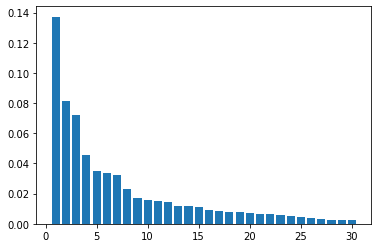

In [104]:
# plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.bar(range(1,31), pca.explained_variance_ratio_[1:31])

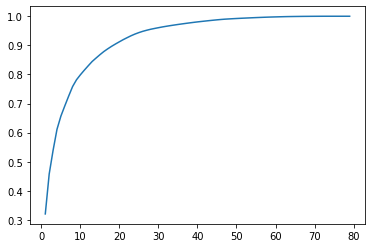

In [105]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making the scree plot
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [106]:
pd.DataFrame(var_cumu).head(30)

0
0   0.320416
1   0.457657
2   0.539140
3   0.611364
4   0.656749
5   0.691842
6   0.725786
7   0.758338
8   0.781596
9   0.798828
10  0.814576
11  0.829673
12  0.844310
13  0.856165
14  0.867745
15  0.878597
16  0.887973
17  0.896674
18  0.904700
19  0.912305
20  0.919753
21  0.926497
22  0.933085
23  0.938852
24  0.943867
25  0.948262
26  0.951917
27  0.955236
28  0.957995
29  0.960628

<font color='green'>
<b>PCA Inference:</b> <br>
- 94% of the variance is explained by the first 20 Principal Components <br>
- We can try running models with 20 components and check how they perform
</font>

## Create PCA datasets

In [107]:
num_pcs = 20

In [108]:
# Get the top 20 principal components 
pcs = IncrementalPCA(n_components=num_pcs)

In [109]:
# Utility method to create the new principal component datasets on the train & test data
def create_pca_data(train,test):
    train_pca = pd.DataFrame(pcs.fit_transform(train)).add_prefix('PC')
    # Index is lost after PCA as it works on Numpy arrays. 
    # Ref: https://github.com/scikit-learn/scikit-learn/issues/8238
    train_pca.index = train.index
    print(f'Train PCA data shape:{train_pca.shape}')
    display(train_pca.head(3))

    test_pca = pd.DataFrame(pcs.transform(test)).add_prefix('PC')
    test_pca.index = test.index
    print(f'Test PCA data shape:{test_pca.shape}')
    display(test_pca.head(3))
    
    
    
    return train_pca, test_pca
    

In [110]:
# Create PCA dataset for the original dataset
X_train_pca, X_test_pca = create_pca_data(X_train,X_test)

Train PCA data shape:(20589, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
39295  0.119463  0.136635  0.180369 -0.077363 -0.040935  0.040210  0.000901   
69317 -0.077687 -0.173394  0.201289 -0.079776  0.031692  0.113800 -0.003188   
56470  0.202023 -0.181798 -0.057123 -0.014601 -0.093506  0.067844 -0.008215   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
39295 -0.066234  0.082315 -0.089383 -0.066793  0.023757  0.017997  0.053965   
69317  0.016474  0.229513 -0.192123 -0.021550 -0.006341  0.092423  0.009401   
56470 -0.086296 -0.073510 -0.054369  0.032009  0.037526  0.027146  0.092443   

           PC14      PC15      PC16      PC17      PC18      PC19  
39295  0.033582 -0.023163  0.000252  0.007463 -0.012185 -0.042999  
69317  0.006022  0.001052  0.036853 -0.016139  0.001436 -0.023013  
56470  0.133232 -0.048564  0.048577 -0.100500 -0.022248 -0.043344

Test PCA data shape:(8825, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
56927  0.138773 -0.125787  0.203461 -0.069228 -0.124441  0.099289 -0.088451   
74526  0.249358 -0.057954  0.248623  1.175060  0.003513  0.429069  0.058667   
71264  0.041176 -0.125393  0.525554 -0.200623  0.014861  0.012984 -0.005262   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
56927 -0.185558 -0.363777  0.057050  0.040924 -0.004759 -0.079514 -0.021701   
74526  0.194017 -0.133618  0.215298 -0.042300 -0.058623  0.155702 -0.090769   
71264 -0.019995 -0.002353 -0.091370  0.034404 -0.030815  0.048950 -0.038075   

           PC14      PC15      PC16      PC17      PC18      PC19  
56927  0.023705 -0.007502  0.091687 -0.010670 -0.027986 -0.034413  
74526 -0.277384 -0.745892 -0.546199 -0.324269  0.129784 -0.137318  
71264 -0.032404  0.014554  0.003908  0.069419 -0.022400 -0.041694

In [111]:
# Create PCA dataset for the oversampled dataset
X_oversampled_train_pca, X_oversampled_test_pca = create_pca_data(X_oversampled_train,X_oversampled_test)

Train PCA data shape:(37927, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
8832  -0.815952 -0.114915  0.190273 -0.022094 -0.309244  0.017523  0.115578   
29160 -0.066468 -0.113777  0.080288 -0.021257  0.095303 -0.151346  0.170301   
33763  0.257402 -0.122674 -0.193564 -0.039925 -0.041849  0.135241  0.047353   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
8832  -0.075579  0.365369  0.211583  0.540315  0.197600  0.205405 -0.001357   
29160  0.070280 -0.068537 -0.035683 -0.031061  0.018313  0.065061  0.015645   
33763 -0.114870 -0.048299 -0.045611  0.026774  0.069422 -0.134133  0.051162   

           PC14      PC15      PC16      PC17      PC18      PC19  
8832  -0.025612  0.108668  0.045031 -0.182313 -0.258928  0.012991  
29160 -0.001478  0.037699  0.019130 -0.027864  0.005149  0.025322  
33763 -0.045555  0.032037  0.043805 -0.061283 -0.004897 -0.017287

Test PCA data shape:(16255, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
28616 -0.036112  0.638537  0.046923  0.063221  0.074655 -0.112193 -0.038253   
40056 -0.205166 -0.135503 -0.281661 -0.019175 -0.154646  0.118776  0.045397   
37037 -0.090411 -0.153451  0.164815 -0.005146 -0.065182 -0.249254  0.348245   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
28616 -0.039667  0.025403 -0.068169  0.001380 -0.019552 -0.003633 -0.008027   
40056 -0.092105 -0.148685 -0.082402  0.470187  0.123540  0.113746 -0.014828   
37037  0.058747  0.034167  0.116645 -0.004647  0.018278  0.002648 -0.077285   

           PC14      PC15      PC16      PC17      PC18      PC19  
28616  0.003856 -0.014482 -0.028280  0.027154  0.001568  0.012482  
40056  0.016924 -0.008410 -0.010291  0.012211  0.375886 -0.038203  
37037 -0.016697  0.014416  0.002602 -0.008519 -0.012226 -0.065555

In [112]:
# Create PCA dataset for the SMOTE dataset
X_smote_train_pca, X_smote_test_pca = create_pca_data(X_smote_train,X_smote_test)

Train PCA data shape:(37927, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
8832  -0.824491 -0.103221  0.170549  0.031773 -0.344776  0.066268  0.075426   
29160 -0.072448 -0.111246  0.079975 -0.021312  0.108577  0.197075  0.101693   
33763  0.230473 -0.157217 -0.114197 -0.061160  0.024020 -0.067865  0.067573   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
8832  -0.225053  0.278262  0.227478  0.131669  0.532568  0.273478  0.006206   
29160  0.071014 -0.044327 -0.036808 -0.040205 -0.016078  0.054492  0.017519   
33763 -0.068285 -0.036285 -0.077322  0.027872  0.016201 -0.070763  0.051836   

           PC14      PC15      PC16      PC17      PC18      PC19  
8832  -0.012832  0.028631 -0.207206 -0.072556 -0.211380 -0.140348  
29160  0.008805  0.023487 -0.043454 -0.027934  0.019127 -0.009509  
33763  0.021892  0.005800 -0.031398  0.019933 -0.041152  0.029318

Test PCA data shape:(16255, 20)


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
28616 -0.034180  0.643644  0.023844  0.042288  0.091770  0.068950 -0.076766   
40056 -0.050945 -0.258211  0.032607 -0.045567  0.195161  0.078441  0.132029   
37037  0.170742  0.404848  0.062456 -0.018013  0.061059  0.024573 -0.065270   

            PC7       PC8       PC9      PC10      PC11      PC12      PC13  \
28616 -0.030246  0.024505 -0.067418  0.015185 -0.011782  0.002819 -0.002584   
40056  0.043346 -0.050342  0.007119  0.008791 -0.038650  0.032708  0.012352   
37037  0.038489  0.077299 -0.008313  0.058583 -0.013050 -0.047724 -0.055085   

           PC14      PC15      PC16      PC17      PC18      PC19  
28616 -0.014298 -0.006663  0.033187  0.012758  0.015368 -0.014167  
40056  0.017128  0.012798  0.000927 -0.037009  0.011831 -0.004132  
37037 -0.007060 -0.001954  0.041346 -0.046275 -0.047504  0.051098

## Check for multicollinearity - PCA

Verify that the features (Principal Components) created from PCA are not correlated to each other

In [113]:
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape

(20, 20)

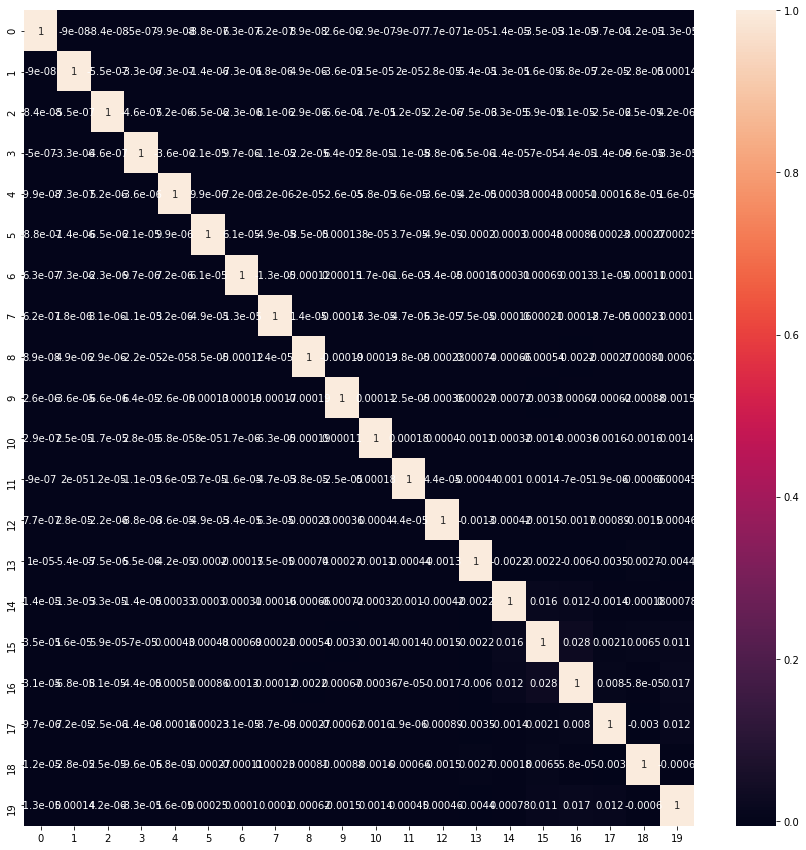

In [114]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

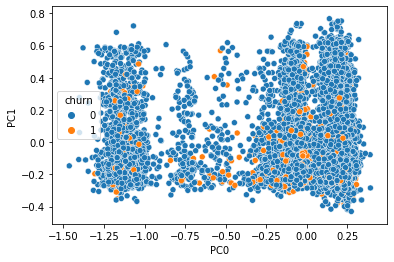

In [115]:
# Plotting the data of PC0 vs PC1
df_final = pd.concat([X_train_pca, y_train], axis=1)
sns.scatterplot(data=df_final, x="PC0", y="PC1",hue="churn")


## Model building - PCA

In [116]:
model_result_pca = pd.DataFrame()

### Default Model Building

In [117]:
# Default model run
run_all_models(X_train_pca, X_test_pca, y_train, y_test,'PCA',model_result_pca)
model_result_pca
#model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.126 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 0.514 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 5.938 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.029 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 11.018 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 2.847 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 2.267 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 22.742 sec


PCA-LR  PCA-DCART  PCA-RF  PCA-NB  PCA-GB  PCA-XGB  \
Accuracy                   92.759     89.020  92.714  91.343  93.076   93.178   
Null Accuracy              91.977     91.977  91.977  91.977  91.977   91.977   
AUROC                      60.094     64.379  60.843  67.060  63.812   63.545   
Sensitivity                21.186     35.028  22.881  38.136  28.955   28.249   
Specificity                99.002     93.729  98.805  95.984  98.669   98.842   
Precision                  64.935     32.761  62.548  45.302  65.495   68.027   
F1 Score                   31.949     33.857  33.506  41.411  40.157   39.920   
Negative Predictive Value  93.507     94.298  93.626  94.677  94.091   94.045   
False Positive Rate         0.998      6.271   1.195   4.016   1.331    1.158   
False Negative Rate        78.814     64.972  77.119  61.864  71.045   71.751   
False Discovery Rate       35.065     67.239  37.452  54.698  34.505   31.973   

                           PCA-ABC  
Accuracy                    92.771  
Null Accuracy               91.977  
AUROC                       62.808  
Sensitivity                 27.119  
Specificity                 98.497  
Precision                   61.146  
F1 Score                    37.573  
Negative Predictive Value   93.937  
False Positive Rate          1.503  
False Negative Rate         72.881  
False Discovery Rate        38.854

In [118]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

Accuracy  Null Accuracy   AUROC  Sensitivity  Specificity  \
PCA-NB       91.343         91.977  67.060       38.136       95.984   
PCA-GB       93.076         91.977  63.812       28.955       98.669   
PCA-XGB      93.178         91.977  63.545       28.249       98.842   
PCA-ABC      92.771         91.977  62.808       27.119       98.497   
PCA-DCART    89.020         91.977  64.379       35.028       93.729   
PCA-RF       92.714         91.977  60.843       22.881       98.805   
PCA-LR       92.759         91.977  60.094       21.186       99.002   

           Precision  F1 Score  Negative Predictive Value  \
PCA-NB        45.302    41.411                     94.677   
PCA-GB        65.495    40.157                     94.091   
PCA-XGB       68.027    39.920                     94.045   
PCA-ABC       61.146    37.573                     93.937   
PCA-DCART     32.761    33.857                     94.298   
PCA-RF        62.548    33.506                     93.626   
PCA-LR        64.935    31.949                     93.507   

           False Positive Rate  False Negative Rate  False Discovery Rate  
PCA-NB                   4.016               61.864                54.698  
PCA-GB                   1.331               71.045                34.505  
PCA-XGB                  1.158               71.751                31.973  
PCA-ABC                  1.503               72.881                38.854  
PCA-DCART                6.271               64.972                67.239  
PCA-RF                   1.195               77.119                37.452  
PCA-LR                   0.998               78.814                35.065

### Model building with HPT

In [119]:
model_type_pca_hpt = 'PCA-HPT'

#### HPT for Random Forest

In [174]:
# %%time
grid_search_rf.fit(X_train_pca,y_train)
rf_grid_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


In [120]:
# %%time
# random_search_rf.fit(X_train_pca,y_train)
# rf_best_est = random_search_rf.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 2.92 s, sys: 268 ms, total: 3.19 s
Wall time: 1min 43s


In [175]:
model_result_pca[f'{model_type_pca_hpt}-RF'] = model_fit_predict(rf_grid_best_est,X_train_pca, X_test_pca, y_train, y_test)

#### HPT for XGBoost

In [122]:
%%time
random_search_xgb.fit(X_train_pca,y_train)
xgb_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 18.7 s, sys: 255 ms, total: 18.9 s
Wall time: 24min 15s


In [123]:
model_result_pca[f'{model_type_pca_hpt}-XGB'] = model_fit_predict(xgb_best_est,X_train_pca, X_test_pca, y_train, y_test)

### Model on oversampled data

In [124]:
run_all_models(X_oversampled_train_pca, X_oversampled_test_pca, y_oversampled_train, y_oversampled_test,'PCA - Oversampled',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.145 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 0.688 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 9.009 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.044 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 16.214 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 4.883 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 3.402 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 34.386 sec


Accuracy  Null Accuracy   AUROC  Sensitivity  \
PCA-LR                     92.759         91.977  60.094       21.186   
PCA-DCART                  89.020         91.977  64.379       35.028   
PCA-RF                     92.714         91.977  60.843       22.881   
PCA-NB                     91.343         91.977  67.060       38.136   
PCA-GB                     93.076         91.977  63.812       28.955   
PCA-XGB                    93.178         91.977  63.545       28.249   
PCA-ABC                    92.771         91.977  62.808       27.119   
PCA-HPT-RF                 92.567         91.977  59.990       21.186   
PCA-HPT-XGB                93.122         91.977  67.640       37.288   
PCA - Oversampled-LR       81.224         50.132  81.224       80.952   
PCA - Oversampled-DCART    96.401         50.132  96.411      100.000   
PCA - Oversampled-RF       98.499         50.132  98.503      100.000   
PCA - Oversampled-NB       71.701         50.132  71.734       84.160   
PCA - Oversampled-GB       84.208         50.132  84.208       84.160   
PCA - Oversampled-XGB      84.177         50.132  84.178       84.567   
PCA - Oversampled-ABC      81.772         50.132  81.770       81.002   

                         Specificity  Precision  F1 Score  \
PCA-LR                        99.002     64.935    31.949   
PCA-DCART                     93.729     32.761    33.857   
PCA-RF                        98.805     62.548    33.506   
PCA-NB                        95.984     45.302    41.411   
PCA-GB                        98.669     65.495    40.157   
PCA-XGB                       98.842     68.027    39.920   
PCA-ABC                       98.497     61.146    37.573   
PCA-HPT-RF                    98.793     60.484    31.381   
PCA-HPT-XGB                   97.992     61.827    46.520   
PCA - Oversampled-LR          81.495     81.314    81.133   
PCA - Oversampled-DCART       92.821     93.269    96.517   
PCA - Oversampled-RF          97.006     97.078    98.517   
PCA - Oversampled-NB          59.308     67.291    74.786   
PCA - Oversampled-GB          84.256     84.170    84.165   
PCA - Oversampled-XGB         83.789     83.843    84.203   
PCA - Oversampled-ABC         82.538     82.188    81.591   

                         Negative Predictive Value  False Positive Rate  \
PCA-LR                                      93.507                0.998   
PCA-DCART                                   94.298                6.271   
PCA-RF                                      93.626                1.195   
PCA-NB                                      94.677                4.016   
PCA-GB                                      94.091                1.331   
PCA-XGB                                     94.045                1.158   
PCA-ABC                                     93.937                1.503   
PCA-HPT-RF                                  93.494                1.207   
PCA-HPT-XGB                                 94.713                2.008   
PCA - Oversampled-LR                        81.136               18.505   
PCA - Oversampled-DCART                    100.000                7.179   
PCA - Oversampled-RF                       100.000                2.994   
PCA - Oversampled-NB                        79.009               40.692   
PCA - Oversampled-GB                        84.245               15.744   
PCA - Oversampled-XGB                       84.515               16.211   
PCA - Oversampled-ABC                       81.369               17.462   

                         False Negative Rate  False Discovery Rate  
PCA-LR                                78.814                35.065  
PCA-DCART                             64.972                67.239  
PCA-RF                                77.119                37.452  
PCA-NB                                61.864                54.698  
PCA-GB                                71.045                34.505  
PCA-XGB                               71.751           

### Model on SMOTE data

In [125]:
run_all_models(X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test,'PCA - SMOTE',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.148 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.192 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 13.217 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.045 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 20.684 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 5.547 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 4.304 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 45.138 sec


Accuracy  Null Accuracy   AUROC  Sensitivity  \
PCA-LR                     92.759         91.977  60.094       21.186   
PCA-DCART                  89.020         91.977  64.379       35.028   
PCA-RF                     92.714         91.977  60.843       22.881   
PCA-NB                     91.343         91.977  67.060       38.136   
PCA-GB                     93.076         91.977  63.812       28.955   
PCA-XGB                    93.178         91.977  63.545       28.249   
PCA-ABC                    92.771         91.977  62.808       27.119   
PCA-HPT-RF                 92.567         91.977  59.990       21.186   
PCA-HPT-XGB                93.122         91.977  67.640       37.288   
PCA - Oversampled-LR       81.224         50.132  81.224       80.952   
PCA - Oversampled-DCART    96.401         50.132  96.411      100.000   
PCA - Oversampled-RF       98.499         50.132  98.503      100.000   
PCA - Oversampled-NB       71.701         50.132  71.734       84.160   
PCA - Oversampled-GB       84.208         50.132  84.208       84.160   
PCA - Oversampled-XGB      84.177         50.132  84.178       84.567   
PCA - Oversampled-ABC      81.772         50.132  81.770       81.002   
PCA - SMOTE-LR             83.119         50.132  83.121       83.716   
PCA - SMOTE-DCART          86.613         50.132  86.617       87.972   
PCA - SMOTE-RF             93.707         50.132  93.711       95.275   
PCA - SMOTE-NB             69.166         50.132  69.217       88.441   
PCA - SMOTE-GB             86.010         50.132  86.012       86.430   
PCA - SMOTE-XGB            85.789         50.132  85.790       86.220   
PCA - SMOTE-ABC            83.796         50.132  83.796       83.950   

                         Specificity  Precision  F1 Score  \
PCA-LR                        99.002     64.935    31.949   
PCA-DCART                     93.729     32.761    33.857   
PCA-RF                        98.805     62.548    33.506   
PCA-NB                        95.984     45.302    41.411   
PCA-GB                        98.669     65.495    40.157   
PCA-XGB                       98.842     68.027    39.920   
PCA-ABC                       98.497     61.146    37.573   
PCA-HPT-RF                    98.793     60.484    31.381   
PCA-HPT-XGB                   97.992     61.827    46.520   
PCA - Oversampled-LR          81.495     81.314    81.133   
PCA - Oversampled-DCART       92.821     93.269    96.517   
PCA - Oversampled-RF          97.006     97.078    98.517   
PCA - Oversampled-NB          59.308     67.291    74.786   
PCA - Oversampled-GB          84.256     84.170    84.165   
PCA - Oversampled-XGB         83.789     83.843    84.203   
PCA - Oversampled-ABC         82.538     82.188    81.591   
PCA - SMOTE-LR                82.525     82.655    83.182   
PCA - SMOTE-DCART             85.262     85.586    86.762   
PCA - SMOTE-RF                92.146     92.347    93.788   
PCA - SMOTE-NB                49.994     63.758    74.098   
PCA - SMOTE-GB                85.593     85.648    86.037   
PCA - SMOTE-XGB               85.360     85.419    85.818   
PCA - SMOTE-ABC               83.642     83.620    83.785   

                         Negative Predictive Value  False Positive Rate  \
PCA-LR                                      93.507                0.998   
PCA-DCART                                   94.298                6.271   
PCA-RF                                      93.626                1.195   
PCA-NB                                      94.677                4.016   
PCA-GB                                      94.091                1.331   
PCA-XGB                                     94.045                1.158   
PCA-ABC                                     93.937                1.503   
PCA-HPT-RF                                  93.494                1.207   
PCA-HPT-XGB                                 94.713                2.008   
PCA - Oversampled-LR                        81.136       

### Model on (SMOTE + HPT)

In [126]:
model_type_pca_smotehpt = 'PCA-SMOTE+HPT'

#### SMOTE+HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_grid_smote_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


In [ ]:
# %%time

# random_search_rf.fit(X_smote_train_pca,y_smote_train)
# rf_smote_best_est = random_search_rf.best_estimator_


In [ ]:
model_result_pca[f'{model_type_pca_smotehpt}-RF'] = model_fit_predict(rf_grid_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

####  SMOTE+HPT for XGBoost

In [129]:
model_result_pca.T

Accuracy  Null Accuracy   AUROC  Sensitivity  \
PCA-LR                     92.759         91.977  60.094       21.186   
PCA-DCART                  89.020         91.977  64.379       35.028   
PCA-RF                     92.714         91.977  60.843       22.881   
PCA-NB                     91.343         91.977  67.060       38.136   
PCA-GB                     93.076         91.977  63.812       28.955   
PCA-XGB                    93.178         91.977  63.545       28.249   
PCA-ABC                    92.771         91.977  62.808       27.119   
PCA-HPT-RF                 92.567         91.977  59.990       21.186   
PCA-HPT-XGB                93.122         91.977  67.640       37.288   
PCA - Oversampled-LR       81.224         50.132  81.224       80.952   
PCA - Oversampled-DCART    96.401         50.132  96.411      100.000   
PCA - Oversampled-RF       98.499         50.132  98.503      100.000   
PCA - Oversampled-NB       71.701         50.132  71.734       84.160   
PCA - Oversampled-GB       84.208         50.132  84.208       84.160   
PCA - Oversampled-XGB      84.177         50.132  84.178       84.567   
PCA - Oversampled-ABC      81.772         50.132  81.770       81.002   
PCA - SMOTE-LR             83.119         50.132  83.121       83.716   
PCA - SMOTE-DCART          86.613         50.132  86.617       87.972   
PCA - SMOTE-RF             93.707         50.132  93.711       95.275   
PCA - SMOTE-NB             69.166         50.132  69.217       88.441   
PCA - SMOTE-GB             86.010         50.132  86.012       86.430   
PCA - SMOTE-XGB            85.789         50.132  85.790       86.220   
PCA - SMOTE-ABC            83.796         50.132  83.796       83.950   
PCA-SMOTE+HPT-RF           90.661         50.132  90.664       91.735   

                         Specificity  Precision  F1 Score  \
PCA-LR                        99.002     64.935    31.949   
PCA-DCART                     93.729     32.761    33.857   
PCA-RF                        98.805     62.548    33.506   
PCA-NB                        95.984     45.302    41.411   
PCA-GB                        98.669     65.495    40.157   
PCA-XGB                       98.842     68.027    39.920   
PCA-ABC                       98.497     61.146    37.573   
PCA-HPT-RF                    98.793     60.484    31.381   
PCA-HPT-XGB                   97.992     61.827    46.520   
PCA - Oversampled-LR          81.495     81.314    81.133   
PCA - Oversampled-DCART       92.821     93.269    96.517   
PCA - Oversampled-RF          97.006     97.078    98.517   
PCA - Oversampled-NB          59.308     67.291    74.786   
PCA - Oversampled-GB          84.256     84.170    84.165   
PCA - Oversampled-XGB         83.789     83.843    84.203   
PCA - Oversampled-ABC         82.538     82.188    81.591   
PCA - SMOTE-LR                82.525     82.655    83.182   
PCA - SMOTE-DCART             85.262     85.586    86.762   
PCA - SMOTE-RF                92.146     92.347    93.788   
PCA - SMOTE-NB                49.994     63.758    74.098   
PCA - SMOTE-GB                85.593     85.648    86.037   
PCA - SMOTE-XGB               85.360     85.419    85.818   
PCA - SMOTE-ABC               83.642     83.620    83.785   
PCA-SMOTE+HPT-RF              89.594     89.763    90.738   

                         Negative Predictive Value  False Positive Rate  \
PCA-LR                                      93.507                0.998   
PCA-DCART                                   94.298                6.271   
PCA-RF                                      93.626                1.195   
PCA-NB                                      94.677                4.016   
PCA-GB                                      94.091                1.331   
PCA-XGB                                     94.045                1.158   
PCA-ABC                                     93.937                1.503   
PCA-HPT-RF                                  93.494                1.207  

In [130]:
%%time
random_search_xgb.fit(X_smote_train_pca,y_smote_train)
xgb_smote_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 1min 35s, sys: 346 ms, total: 1min 35s
Wall time: 51min 50s


In [131]:
model_result_pca[f'{model_type_pca_smotehpt}-XGB'] = model_fit_predict(xgb_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

## Summary from all models

In [132]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

Accuracy  Null Accuracy   AUROC  Sensitivity  \
PCA - Oversampled-RF       98.499         50.132  98.503      100.000   
PCA - Oversampled-DCART    96.401         50.132  96.411      100.000   
PCA-SMOTE+HPT-XGB          94.943         50.132  94.949       97.249   
PCA - SMOTE-RF             93.707         50.132  93.711       95.275   
PCA-SMOTE+HPT-RF           90.661         50.132  90.664       91.735   
PCA - SMOTE-DCART          86.613         50.132  86.617       87.972   
PCA - SMOTE-GB             86.010         50.132  86.012       86.430   
PCA - SMOTE-XGB            85.789         50.132  85.790       86.220   
PCA - Oversampled-XGB      84.177         50.132  84.178       84.567   
PCA - Oversampled-GB       84.208         50.132  84.208       84.160   
PCA - SMOTE-ABC            83.796         50.132  83.796       83.950   
PCA - SMOTE-LR             83.119         50.132  83.121       83.716   
PCA - Oversampled-ABC      81.772         50.132  81.770       81.002   
PCA - Oversampled-LR       81.224         50.132  81.224       80.952   
PCA - Oversampled-NB       71.701         50.132  71.734       84.160   
PCA - SMOTE-NB             69.166         50.132  69.217       88.441   
PCA-HPT-XGB                93.122         91.977  67.640       37.288   
PCA-NB                     91.343         91.977  67.060       38.136   
PCA-GB                     93.076         91.977  63.812       28.955   
PCA-XGB                    93.178         91.977  63.545       28.249   
PCA-ABC                    92.771         91.977  62.808       27.119   
PCA-DCART                  89.020         91.977  64.379       35.028   
PCA-RF                     92.714         91.977  60.843       22.881   
PCA-LR                     92.759         91.977  60.094       21.186   
PCA-HPT-RF                 92.567         91.977  59.990       21.186   

                         Specificity  Precision  F1 Score  \
PCA - Oversampled-RF          97.006     97.078    98.517   
PCA - Oversampled-DCART       92.821     93.269    96.517   
PCA-SMOTE+HPT-XGB             92.649     92.938    95.045   
PCA - SMOTE-RF                92.146     92.347    93.788   
PCA-SMOTE+HPT-RF              89.594     89.763    90.738   
PCA - SMOTE-DCART             85.262     85.586    86.762   
PCA - SMOTE-GB                85.593     85.648    86.037   
PCA - SMOTE-XGB               85.360     85.419    85.818   
PCA - Oversampled-XGB         83.789     83.843    84.203   
PCA - Oversampled-GB          84.256     84.170    84.165   
PCA - SMOTE-ABC               83.642     83.620    83.785   
PCA - SMOTE-LR                82.525     82.655    83.182   
PCA - Oversampled-ABC         82.538     82.188    81.591   
PCA - Oversampled-LR          81.495     81.314    81.133   
PCA - Oversampled-NB          59.308     67.291    74.786   
PCA - SMOTE-NB                49.994     63.758    74.098   
PCA-HPT-XGB                   97.992     61.827    46.520   
PCA-NB                        95.984     45.302    41.411   
PCA-GB                        98.669     65.495    40.157   
PCA-XGB                       98.842     68.027    39.920   
PCA-ABC                       98.497     61.146    37.573   
PCA-DCART                     93.729     32.761    33.857   
PCA-RF                        98.805     62.548    33.506   
PCA-LR                        99.002     64.935    31.949   
PCA-HPT-RF                    98.793     60.484    31.381   

                         Negative Predictive Value  False Positive Rate  \
PCA - Oversampled-RF                       100.000                2.994   
PCA - Oversampled-DCART                    100.000                7.179   
PCA-SMOTE+HPT-XGB                           97.131                7.351   
PCA - SMOTE-RF                              95.147                7.854   
PCA-SMOTE+HPT-RF                            91.595               10.406   
PCA - SMOTE-DCART                           87.694               14.738   
PCA - SMOTE-GB

<font color = 'green'>
    <b>Insights from the summary table - PCA</b><br>
- Models with oversampled data & smote data perform better than the models without any class imbalance treatement <br> 
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

# Model building 2 - without PCA

## Build  Models

In [133]:
model_result_featimp = pd.DataFrame()

### Default model building

In [134]:
# Default model run - Feature Importance (FI)
run_all_models(X_train, X_test, y_train, y_test,'FI', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.321 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.098 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 6.029 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.06 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 16.866 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 7.673 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 3.566 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 35.615 sec


Accuracy  Null Accuracy   AUROC  Sensitivity  Specificity  \
FI-XGB      94.663         91.977  75.053       51.695       98.411   
FI-GB       94.561         91.977  74.417       50.424       98.411   
FI-ABC      94.153         91.977  73.422       48.729       98.115   
FI-RF       94.289         91.977  70.273       41.667       98.879   
FI-DCART    91.275         91.977  71.599       48.164       95.035   
FI-LR       92.884         91.977  60.742       22.458       99.027   
FI-NB       47.150         91.977  66.500       89.548       43.452   

          Precision  F1 Score  Negative Predictive Value  False Positive Rate  \
FI-XGB       73.939    60.848                     95.894                1.589   
FI-GB        73.457    59.799                     95.791                1.589   
FI-ABC       69.277    57.214                     95.641                1.885   
FI-RF        76.425    53.931                     95.106                1.121   
FI-DCART     45.833    46.970                     95.458                4.965   
FI-LR        66.807    33.615                     93.607                0.973   
FI-NB        12.136    21.376                     97.945               56.548   

          False Negative Rate  False Discovery Rate  
FI-XGB                 48.305                26.061  
FI-GB                  49.576                26.543  
FI-ABC                 51.271                30.723  
FI-RF                  58.333                23.575  
FI-DCART               51.836                54.167  
FI-LR                  77.542                33.193  
FI-NB                  10.452                87.864

### Model with HPT

In [135]:
model_type_FI_hpt = 'FI-HPT'

#### HPT for Random Forest

In [173]:
%%time
grid_search_rf.fit(X_train,y_train)
rf_fi_grid_best_est = grid_search_rf.best_estimator_

Fitting 4 folds for each of 375 candidates, totalling 1500 fits
CPU times: user 10.3 s, sys: 808 ms, total: 11.1 s
Wall time: 4min 31s


In [136]:
# %%time
# random_search_rf.fit(X_train,y_train)
# rf_fi_best_est = random_search_rf.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 4.37 s, sys: 360 ms, total: 4.73 s
Wall time: 1min 3s


In [ ]:
model_result_featimp[f'{model_type_FI_hpt}-RF'] = model_fit_predict(rf_fi_grid_best_est,X_train, X_test, y_train, y_test)

#### HPT for XGBoost

In [138]:
%%time
random_search_xgb.fit(X_train,y_train)
xgb_fi_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 1min 12s, sys: 308 ms, total: 1min 12s
Wall time: 57min 24s


In [139]:
model_result_featimp[f'{model_type_FI_hpt}-XGB'] = model_fit_predict(xgb_fi_best_est,X_train, X_test, y_train, y_test)

### Model with Oversampled Data

In [140]:
run_all_models(X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test,'FI - Oversampled', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.608 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.57 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 9.795 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.098 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 26.043 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 13.776 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 5.692 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 57.582 sec


Accuracy  Null Accuracy   AUROC  Sensitivity  \
FI - Oversampled-RF       98.763         50.132  98.767      100.000   
FI - Oversampled-DCART    97.269         50.132  97.276      100.000   
FI - Oversampled-XGB      90.206         50.132  90.208       90.772   
FI - Oversampled-GB       90.151         50.132  90.152       90.686   
FI - Oversampled-ABC      87.229         50.132  87.228       86.837   
FI - Oversampled-LR       83.341         50.132  83.342       84.024   
FI - Oversampled-NB       66.902         50.132  66.967       91.303   
FI-HPT-XGB                94.742         91.977  76.450       54.661   
FI-XGB                    94.663         91.977  75.053       51.695   
FI-GB                     94.561         91.977  74.417       50.424   
FI-ABC                    94.153         91.977  73.422       48.729   
FI-RF                     94.289         91.977  70.273       41.667   
FI-HPT-RF                 94.232         91.977  69.340       39.689   
FI-DCART                  91.275         91.977  71.599       48.164   
FI-LR                     92.884         91.977  60.742       22.458   
FI-NB                     47.150         91.977  66.500       89.548   

                        Specificity  Precision  F1 Score  \
FI - Oversampled-RF          97.533     97.580    98.775   
FI - Oversampled-DCART       94.551     94.807    97.334   
FI - Oversampled-XGB         89.643     89.710    90.238   
FI - Oversampled-GB          89.618     89.679    90.180   
FI - Oversampled-ABC         87.618     87.463    87.149   
FI - Oversampled-LR          82.660     82.819    83.417   
FI - Oversampled-NB          42.631     61.287    73.343   
FI-HPT-XGB                   98.238     73.019    62.520   
FI-XGB                       98.411     73.939    60.848   
FI-GB                        98.411     73.457    59.799   
FI-ABC                       98.115     69.277    57.214   
FI-RF                        98.879     76.425    53.931   
FI-HPT-RF                    98.990     77.410    52.474   
FI-DCART                     95.035     45.833    46.970   
FI-LR                        99.027     66.807    33.615   
FI-NB                        43.452     12.136    21.376   

                        Negative Predictive Value  False Positive Rate  \
FI - Oversampled-RF                       100.000                2.467   
FI - Oversampled-DCART                    100.000                5.449   
FI - Oversampled-XGB                       90.712               10.357   
FI - Oversampled-GB                        90.630               10.382   
FI - Oversampled-ABC                       86.999               12.382   
FI - Oversampled-LR                        83.875               17.340   
FI - Oversampled-NB                        83.130               57.369   
FI-HPT-XGB                                 96.130                1.762   
FI-XGB                                     95.894                1.589   
FI-GB                                      95.791                1.589   
FI-ABC                                     95.641                1.885   
FI-RF                                      95.106                1.121   
FI-HPT-RF                                  94.954                1.010   
FI-DCART                                   95.458                4.965   
FI-LR                                      93.607                0.973   
FI-NB                                      97.945               56.548   

                        False Negative Rate  False Discovery Rate  
FI - Oversampled-RF                   0.000                 2.420  
FI - Oversampled-DCART                0.000                 5.193  
FI - Oversampled-XGB                  9.228                10.290  
FI - Oversampled-GB                   9.314                10.321  
FI - Oversampled-ABC                 13.163                12.537  
FI - Oversampled-LR                  15.976                17.181  
FI - Oversampled-NB                   8.697

### Model with SMOTE Data

In [141]:
run_all_models(X_smote_train, X_smote_test, y_smote_train, y_smote_test,'FI - SMOTE', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.596 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 2.918 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 14.589 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.099 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 37.663 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 15.28 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 7.895 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 78.04 sec


Accuracy  Null Accuracy   AUROC  Sensitivity  \
FI - Oversampled-RF       98.763         50.132  98.767      100.000   
FI - Oversampled-DCART    97.269         50.132  97.276      100.000   
FI - SMOTE-RF             96.629         50.132  96.631       97.422   
FI - SMOTE-GB             93.337         50.132  93.339       94.066   
FI - SMOTE-XGB            93.104         50.132  93.107       94.202   
FI - SMOTE-DCART          92.027         50.132  92.031       93.511   
FI - SMOTE-ABC            91.578         50.132  91.579       91.920   
FI - Oversampled-XGB      90.206         50.132  90.208       90.772   
FI - Oversampled-GB       90.151         50.132  90.152       90.686   
FI - Oversampled-ABC      87.229         50.132  87.228       86.837   
FI - SMOTE-LR             86.472         50.132  86.475       87.824   
FI - Oversampled-LR       83.341         50.132  83.342       84.024   
FI - SMOTE-NB             70.784         50.132  70.840       91.821   
FI - Oversampled-NB       66.902         50.132  66.967       91.303   
FI-HPT-XGB                94.742         91.977  76.450       54.661   
FI-XGB                    94.663         91.977  75.053       51.695   
FI-GB                     94.561         91.977  74.417       50.424   
FI-ABC                    94.153         91.977  73.422       48.729   
FI-RF                     94.289         91.977  70.273       41.667   
FI-HPT-RF                 94.232         91.977  69.340       39.689   
FI-DCART                  91.275         91.977  71.599       48.164   
FI-LR                     92.884         91.977  60.742       22.458   
FI-NB                     47.150         91.977  66.500       89.548   

                        Specificity  Precision  F1 Score  \
FI - Oversampled-RF          97.533     97.580    98.775   
FI - Oversampled-DCART       94.551     94.807    97.334   
FI - SMOTE-RF                95.840     95.884    96.647   
FI - SMOTE-GB                92.613     92.683    93.369   
FI - SMOTE-XGB               92.011     92.144    93.162   
FI - SMOTE-DCART             90.551     90.778    92.124   
FI - SMOTE-ABC               91.238     91.255    91.586   
FI - Oversampled-XGB         89.643     89.710    90.238   
FI - Oversampled-GB          89.618     89.679    90.180   
FI - Oversampled-ABC         87.618     87.463    87.149   
FI - SMOTE-LR                85.127     85.452    86.622   
FI - Oversampled-LR          82.660     82.819    83.417   
FI - SMOTE-NB                49.859     64.559    75.814   
FI - Oversampled-NB          42.631     61.287    73.343   
FI-HPT-XGB                   98.238     73.019    62.520   
FI-XGB                       98.411     73.939    60.848   
FI-GB                        98.411     73.457    59.799   
FI-ABC                       98.115     69.277    57.214   
FI-RF                        98.879     76.425    53.931   
FI-HPT-RF                    98.990     77.410    52.474   
FI-DCART                     95.035     45.833    46.970   
FI-LR                        99.027     66.807    33.615   
FI-NB                        43.452     12.136    21.376   

                        Negative Predictive Value  False Positive Rate  \
FI - Oversampled-RF                       100.000                2.467   
FI - Oversampled-DCART                    100.000                5.449   
FI - SMOTE-RF                              97.394                4.160   
FI - SMOTE-GB                              94.008                7.387   
FI - SMOTE-XGB                             94.101                7.989   
FI - SMOTE-DCART                           93.346                9.449   
FI - SMOTE-ABC                             91.904                8.762   
FI - Oversampled-XGB                       90.712               10.357   
FI - Oversampled-GB                        90.630               10.382   
FI - Oversampled-ABC                       86.999               12.382   
FI - SMOTE-LR                           

### Model with SMOTE+HPT

In [142]:
model_type_FI_smotehpt = 'FI-SMOTE+HPT'

#### HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_grid_fi_smote_best_est = grid_search_rf.best_estimator_

In [ ]:
# %%time

# random_search_rf.fit(X_smote_train,y_smote_train)
# rf_fi_smote_best_est = random_search_rf.best_estimator_


In [ ]:
model_result_featimp[f'{model_type_FI_smotehpt}-RF'] = model_fit_predict(rf_grid_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

#### HPT for XGBoost

In [145]:
%%time
random_search_xgb.fit(X_smote_train,y_smote_train)
xgb_fi_smote_best_est = random_search_xgb.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: user 3min 41s, sys: 453 ms, total: 3min 42s
Wall time: 2h 4min 17s


In [146]:
model_result_featimp[f'{model_type_FI_smotehpt}-XGB'] = model_fit_predict(xgb_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

### Summary from all the Models

Goal: Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

In [147]:

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

Accuracy  Null Accuracy   AUROC  Sensitivity  \
FI - Oversampled-RF       98.763         50.132  98.767      100.000   
FI-SMOTE+HPT-XGB          97.699         50.132  97.701       98.569   
FI - Oversampled-DCART    97.269         50.132  97.276      100.000   
FI - SMOTE-RF             96.629         50.132  96.631       97.422   
FI-SMOTE+HPT-RF           94.143         50.132  94.145       94.856   
FI - SMOTE-GB             93.337         50.132  93.339       94.066   
FI - SMOTE-XGB            93.104         50.132  93.107       94.202   
FI - SMOTE-DCART          92.027         50.132  92.031       93.511   
FI - SMOTE-ABC            91.578         50.132  91.579       91.920   
FI - Oversampled-XGB      90.206         50.132  90.208       90.772   
FI - Oversampled-GB       90.151         50.132  90.152       90.686   
FI - Oversampled-ABC      87.229         50.132  87.228       86.837   
FI - SMOTE-LR             86.472         50.132  86.475       87.824   
FI - Oversampled-LR       83.341         50.132  83.342       84.024   
FI - SMOTE-NB             70.784         50.132  70.840       91.821   
FI - Oversampled-NB       66.902         50.132  66.967       91.303   
FI-HPT-XGB                94.742         91.977  76.450       54.661   
FI-XGB                    94.663         91.977  75.053       51.695   
FI-GB                     94.561         91.977  74.417       50.424   
FI-ABC                    94.153         91.977  73.422       48.729   
FI-RF                     94.289         91.977  70.273       41.667   
FI-HPT-RF                 94.232         91.977  69.340       39.689   
FI-DCART                  91.275         91.977  71.599       48.164   
FI-LR                     92.884         91.977  60.742       22.458   
FI-NB                     47.150         91.977  66.500       89.548   

                        Specificity  Precision  F1 Score  \
FI - Oversampled-RF          97.533     97.580    98.775   
FI-SMOTE+HPT-XGB             96.834     96.872    97.713   
FI - Oversampled-DCART       94.551     94.807    97.334   
FI - SMOTE-RF                95.840     95.884    96.647   
FI-SMOTE+HPT-RF              93.435     93.495    94.170   
FI - SMOTE-GB                92.613     92.683    93.369   
FI - SMOTE-XGB               92.011     92.144    93.162   
FI - SMOTE-DCART             90.551     90.778    92.124   
FI - SMOTE-ABC               91.238     91.255    91.586   
FI - Oversampled-XGB         89.643     89.710    90.238   
FI - Oversampled-GB          89.618     89.679    90.180   
FI - Oversampled-ABC         87.618     87.463    87.149   
FI - SMOTE-LR                85.127     85.452    86.622   
FI - Oversampled-LR          82.660     82.819    83.417   
FI - SMOTE-NB                49.859     64.559    75.814   
FI - Oversampled-NB          42.631     61.287    73.343   
FI-HPT-XGB                   98.238     73.019    62.520   
FI-XGB                       98.411     73.939    60.848   
FI-GB                        98.411     73.457    59.799   
FI-ABC                       98.115     69.277    57.214   
FI-RF                        98.879     76.425    53.931   
FI-HPT-RF                    98.990     77.410    52.474   
FI-DCART                     95.035     45.833    46.970   
FI-LR                        99.027     66.807    33.615   
FI-NB                        43.452     12.136    21.376   

                        Negative Predictive Value  False Positive Rate  \
FI - Oversampled-RF                       100.000                2.467   
FI-SMOTE+HPT-XGB                           98.551                3.166   
FI - Oversampled-DCART                    100.000                5.449   
FI - SMOTE-RF                              97.394                4.160   
FI-SMOTE+HPT-RF                            94.808                6.565   
FI - SMOTE-GB                              94.008                7.387   
FI - SMOTE-XGB                             94.101                7.989  

<font color = 'green'>
<b>Insights from the summary table</b><br>
- Since it is important to identify churners than non-churners, 
- Comparing the model performances in the above summary table, it is clear that the model performs better when the class imbalance issue is addressed.<br>
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

## Best Model for Feature Importance

### Feature Importance with Random Forest & XGB models

In [148]:
print(f'Important features from Random Forest HPT model')

imp_rf_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_grid_fi_best_est.feature_importances_
})
imp_rf_df.sort_values(by="Imp", ascending=False)

Important features from Random Forest HPT model


Varname       Imp
50              arpu_gaphase_avg  0.066308
5                   offnet_mou_8  0.061122
2                    onnet_mou_8  0.048243
41                     fb_user_8  0.045071
64    total_rech_amt_gaphase_avg  0.044327
76            std_og_gaphase_avg  0.038134
52         total_mou_gaphase_avg  0.035514
26              night_pck_user_8  0.034422
47            last_rech_num_days  0.034419
70      max_rech_amt_gaphase_avg  0.032018
59                    loc_ic_avg  0.031005
60            loc_ic_gaphase_avg  0.030636
58            loc_og_gaphase_avg  0.027726
68    total_rech_num_gaphase_avg  0.026078
11                  spl_og_mou_8  0.023347
78            std_ic_gaphase_avg  0.021567
63            total_rech_amt_avg  0.021553
61                  roam_mou_avg  0.021060
74  last_day_rch_amt_gaphase_avg  0.020845
51                 total_mou_avg  0.018353
57                    loc_og_avg  0.017799
62          roam_mou_gaphase_avg  0.016974
73          last_day_rch_amt_avg  0.015865
69              max_rech_amt_avg  0.015136
49                      arpu_avg  0.014810
4                   offnet_mou_7  0.013946
71             max_rech_data_avg  0.012060
1                    onnet_mou_7  0.011738
54               vol_gaphase_avg  0.011610
42                           aon  0.010594
..                           ...       ...
39                     fb_user_6  0.003755
56        loc_t2c_og_gaphase_avg  0.003707
12                   og_others_6  0.003080
30                   sachet_2g_6  0.002620
17                  spl_ic_mou_8  0.002599
20                  isd_ic_mou_8  0.002483
32                   sachet_2g_8  0.002477
18                  isd_ic_mou_6  0.002156
45                    jun_vbc_3g  0.002121
21                   ic_others_6  0.001989
31                   sachet_2g_7  0.001890
29                  monthly_2g_8  0.001755
22                   ic_others_7  0.001704
15                  spl_ic_mou_6  0.001674
19                  isd_ic_mou_7  0.001317
6                   isd_og_mou_6  0.001135
37                   sachet_3g_7  0.001097
46                    sep_vbc_3g  0.000790
36                   sachet_3g_6  0.000778
7                   isd_og_mou_7  0.000776
33                  monthly_3g_6  0.000768
38                   sachet_3g_8  0.000624
34                  monthly_3g_7  0.000618
27                  monthly_2g_6  0.000592
35                  monthly_3g_8  0.000547
16                  spl_ic_mou_7  0.000478
8                   isd_og_mou_8  0.000343
28                  monthly_2g_7  0.000190
13                   og_others_7  0.000015
14                   og_others_8  0.000000

[79 rows x 2 columns]

In [149]:
print(f'Important features from XGB HPT model')

imp_xgb_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": xgb_fi_best_est.feature_importances_
})
imp_xgb_df.sort_values(by="Imp", ascending=False)

Important features from XGB HPT model


Varname       Imp
5                   offnet_mou_8  0.066321
41                     fb_user_8  0.057911
26              night_pck_user_8  0.050876
50              arpu_gaphase_avg  0.045281
52         total_mou_gaphase_avg  0.041868
2                    onnet_mou_8  0.025310
40                     fb_user_7  0.020318
62          roam_mou_gaphase_avg  0.020246
76            std_og_gaphase_avg  0.020097
47            last_rech_num_days  0.017963
17                  spl_ic_mou_8  0.017724
46                    sep_vbc_3g  0.017204
64    total_rech_amt_gaphase_avg  0.016509
11                  spl_og_mou_8  0.016210
23                   ic_others_8  0.015697
60            loc_ic_gaphase_avg  0.015194
25              night_pck_user_7  0.014421
51                 total_mou_avg  0.014373
59                    loc_ic_avg  0.014170
61                  roam_mou_avg  0.014083
27                  monthly_2g_6  0.013784
71             max_rech_data_avg  0.013759
70      max_rech_amt_gaphase_avg  0.013339
53                       vol_avg  0.013059
74  last_day_rch_amt_gaphase_avg  0.012828
32                   sachet_2g_8  0.011833
39                     fb_user_6  0.011807
57                    loc_og_avg  0.011792
78            std_ic_gaphase_avg  0.011191
73          last_day_rch_amt_avg  0.011163
..                           ...       ...
42                           aon  0.007881
1                    onnet_mou_7  0.007828
0                    onnet_mou_6  0.007812
10                  spl_og_mou_7  0.007731
9                   spl_og_mou_6  0.007554
31                   sachet_2g_7  0.007498
33                  monthly_3g_6  0.007377
15                  spl_ic_mou_6  0.007325
55                loc_t2c_og_avg  0.007034
36                   sachet_3g_6  0.007004
12                   og_others_6  0.006766
18                  isd_ic_mou_6  0.006650
56        loc_t2c_og_gaphase_avg  0.006452
45                    jun_vbc_3g  0.006399
29                  monthly_2g_8  0.006340
6                   isd_og_mou_6  0.006284
44                    jul_vbc_3g  0.006186
22                   ic_others_7  0.006151
8                   isd_og_mou_8  0.005989
34                  monthly_3g_7  0.005907
7                   isd_og_mou_7  0.005890
19                  isd_ic_mou_7  0.005873
37                   sachet_3g_7  0.005312
16                  spl_ic_mou_7  0.005281
21                   ic_others_6  0.004899
28                  monthly_2g_7  0.004818
35                  monthly_3g_8  0.004518
38                   sachet_3g_8  0.000000
13                   og_others_7  0.000000
14                   og_others_8  0.000000

[79 rows x 2 columns]

In [150]:
print(f'Important features from RF - oversampled model')
model_rf_oversampled = RandomForestClassifier(random_state=42).fit(X_oversampled_train, y_oversampled_train)

imp_rf_oversampled_df = pd.DataFrame({
    "Varname": X_oversampled_train.columns,
    "Imp": model_rf_oversampled.feature_importances_
})
imp_rf_oversampled_df.sort_values(by="Imp", ascending=False)

Important features from RF - oversampled model


Varname       Imp
64    total_rech_amt_gaphase_avg  0.053350
41                     fb_user_8  0.051799
52         total_mou_gaphase_avg  0.051652
50              arpu_gaphase_avg  0.048196
60            loc_ic_gaphase_avg  0.045832
47            last_rech_num_days  0.039942
5                   offnet_mou_8  0.035742
62          roam_mou_gaphase_avg  0.034284
2                    onnet_mou_8  0.033039
59                    loc_ic_avg  0.031846
68    total_rech_num_gaphase_avg  0.031835
76            std_og_gaphase_avg  0.027424
70      max_rech_amt_gaphase_avg  0.026420
74  last_day_rch_amt_gaphase_avg  0.025053
58            loc_og_gaphase_avg  0.024258
61                  roam_mou_avg  0.024004
57                    loc_og_avg  0.023165
78            std_ic_gaphase_avg  0.021057
51                 total_mou_avg  0.019791
26              night_pck_user_8  0.018820
11                  spl_og_mou_8  0.014929
73          last_day_rch_amt_avg  0.014138
63            total_rech_amt_avg  0.013973
42                           aon  0.013881
69              max_rech_amt_avg  0.012473
54               vol_gaphase_avg  0.012108
3                   offnet_mou_6  0.011960
4                   offnet_mou_7  0.011216
49                      arpu_avg  0.010922
67            total_rech_num_avg  0.010902
..                           ...       ...
39                     fb_user_6  0.003906
44                    jul_vbc_3g  0.003599
32                   sachet_2g_8  0.003544
45                    jun_vbc_3g  0.003521
20                  isd_ic_mou_8  0.003471
22                   ic_others_7  0.003237
12                   og_others_6  0.003229
15                  spl_ic_mou_6  0.003166
46                    sep_vbc_3g  0.003107
21                   ic_others_6  0.002972
31                   sachet_2g_7  0.002930
18                  isd_ic_mou_6  0.002902
19                  isd_ic_mou_7  0.002857
25              night_pck_user_7  0.002793
30                   sachet_2g_6  0.002235
7                   isd_og_mou_7  0.001975
8                   isd_og_mou_8  0.001686
29                  monthly_2g_8  0.001528
6                   isd_og_mou_6  0.001477
16                  spl_ic_mou_7  0.001274
37                   sachet_3g_7  0.001249
36                   sachet_3g_6  0.001164
28                  monthly_2g_7  0.001053
33                  monthly_3g_6  0.001036
34                  monthly_3g_7  0.001031
27                  monthly_2g_6  0.000905
35                  monthly_3g_8  0.000887
38                   sachet_3g_8  0.000874
13                   og_others_7  0.000292
14                   og_others_8  0.000063

[79 rows x 2 columns]

## Correlation matrix with the target for the important features

In [169]:
imp_features = ['total_rech_amt_gaphase_avg','fb_user_8','total_mou_gaphase_avg','arpu_gaphase_avg','loc_ic_gaphase_avg','last_rech_num_days']

In [170]:
df = cust[imp_features + ['churn']]
corr = df.corr() 

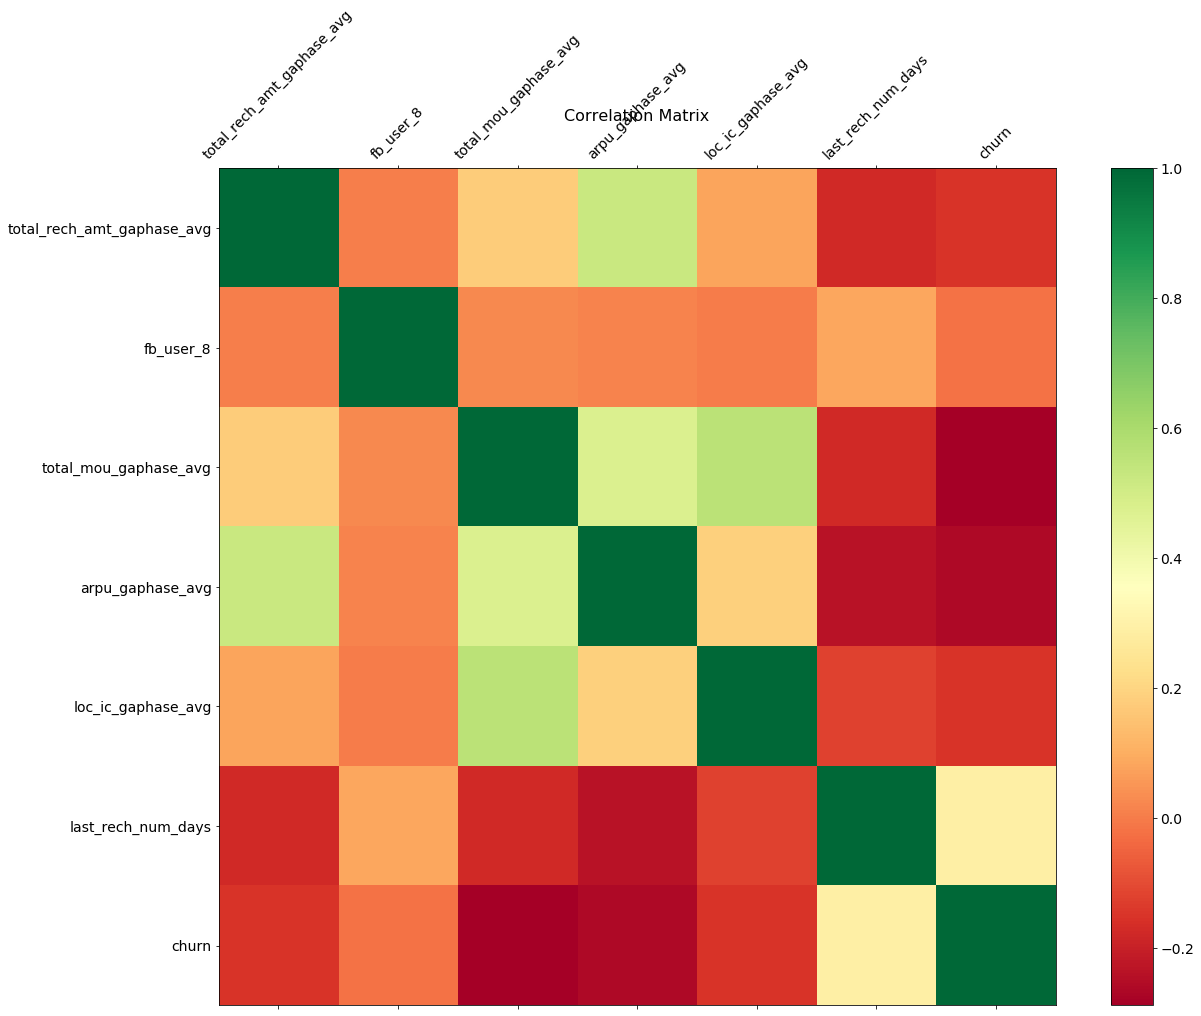

In [171]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [172]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

# Insights

## Best Model - with PCA

Finally, choose a model based on some evaluation metric.

<font color='green'>
<b>Approach:</b> <br>
- Models were created with 3 different types of data: <br>
-- Input Data<br>
-- Oversampled Data<br>
-- SMOTE Data<br>
- Based on the F1-Score and AUROC, we can notice that the models created with the oversampled data before the best.<br>
- <br>
- The models with oversampled data perform better than the <br>
</font>

## Important features

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.